In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import datetime

# Definición del problema

## Predecir la probabilidad de atraso en vuelos en el aeropuerto de Santiago SCL

In [2]:
df = pd.read_csv('dataset_SCL.csv')

/var/folders/qw/7c7_xnp52774fbcz_h1twtt80000gn/T/ipykernel_84474/3467307737.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset_SCL.csv')


In [3]:
df.shape

(68206, 18)

# EDA

Pasos a seguir:
- Graficar distribuciones
- Valores nulos
- Definir la target: propuesta en el enunciado
- Balanceo de la target
- Graficar distintas aperturas según el atraso:
    - Atrasos por día
    - Atrasos por mes
    - Atrasos promedio por día del mes

## Distribuciones

### Ori-I

<Axes: >

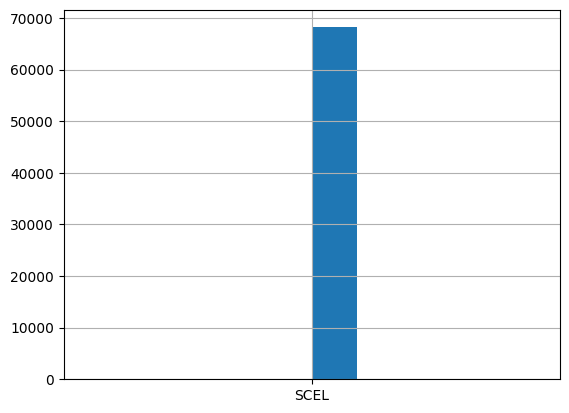

In [4]:
df['Ori-I'].hist()

Todos los vuelos salen de Santiago, Chile

### Des-I

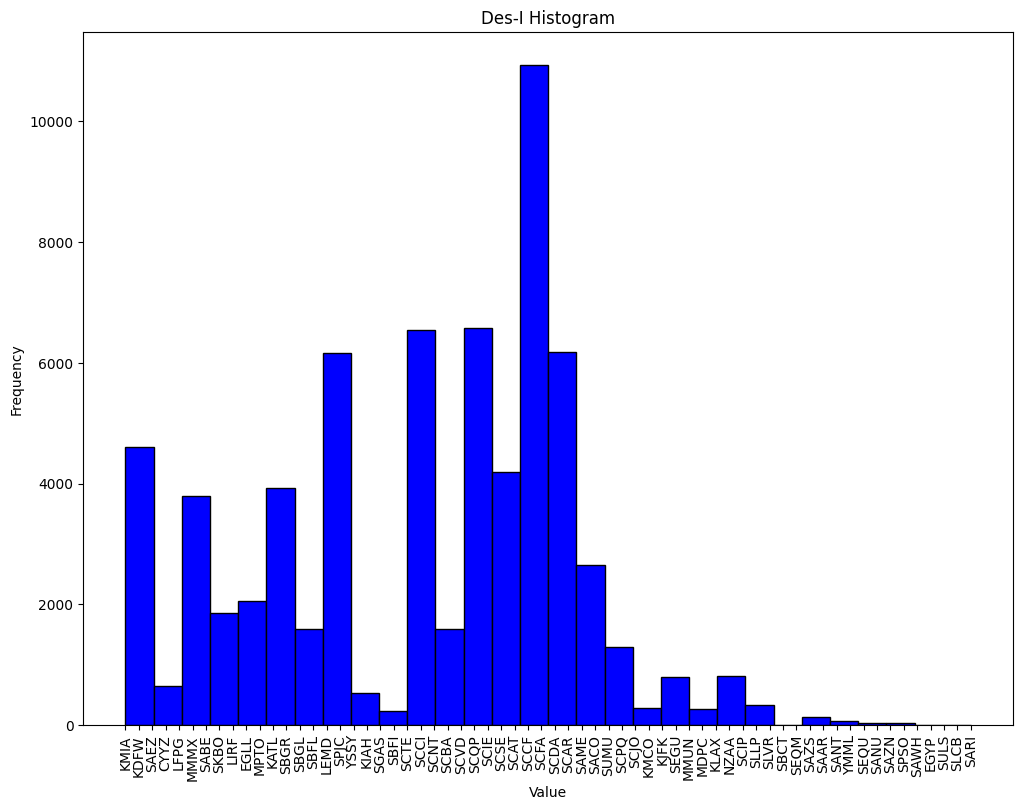

In [5]:
plt.figure(figsize=(12, 9))
plt.hist(df['Des-I'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Des-I Histogram')
plt.xticks(rotation=90)
plt.show()

In [6]:
top_10_destinations = df.value_counts('Des-I').reset_index().sort_values('count', ascending=False).head(10)
top_10_destinations.merge(df[['Des-I','SIGLADES']]).drop_duplicates()

,Des-I,count,SIGLADES
0,SCFA,5787,Antofagasta
2136,SCFA,5787,Calama
5787,SPJC,5270,Lima
11057,SCCF,5145,Calama
16202,SCTE,4357,Puerto Montt
16300,SCTE,4357,Temuco
17669,SCTE,4357,Punta Arenas
20559,SCIE,3995,Concepcion
20829,SCIE,3995,Temuco
24115,SCIE,3995,Puerto Montt


Top 10 destinos según el campo Des-I, tiene más SIGLASDES de lo que debería --> SIGLADES mal etiquetado quizás

### Emp-I

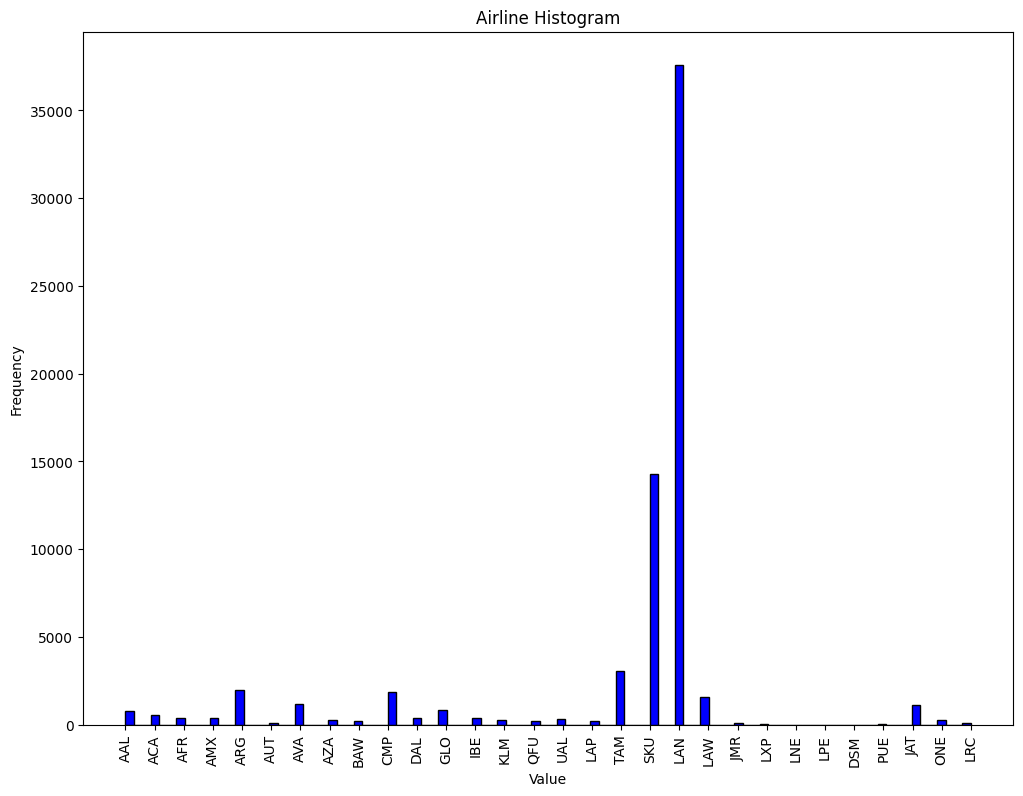

In [7]:
plt.figure(figsize=(12, 9))
plt.hist(df['Emp-I'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Airline Histogram')
plt.xticks(rotation=90)
plt.show()

La mayoría de la base tiene vuelos de LAN y SKU

### Ori-O

<Axes: >

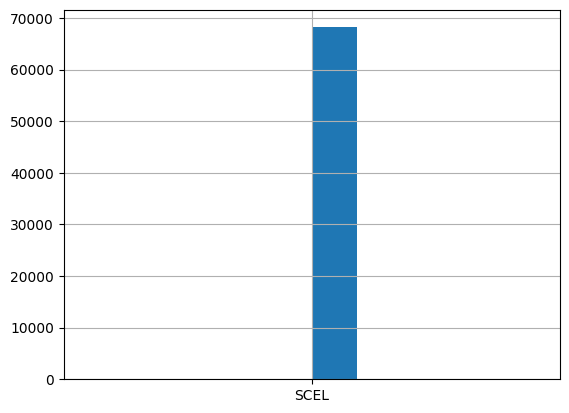

In [8]:
df['Ori-O'].hist()

### Des-O

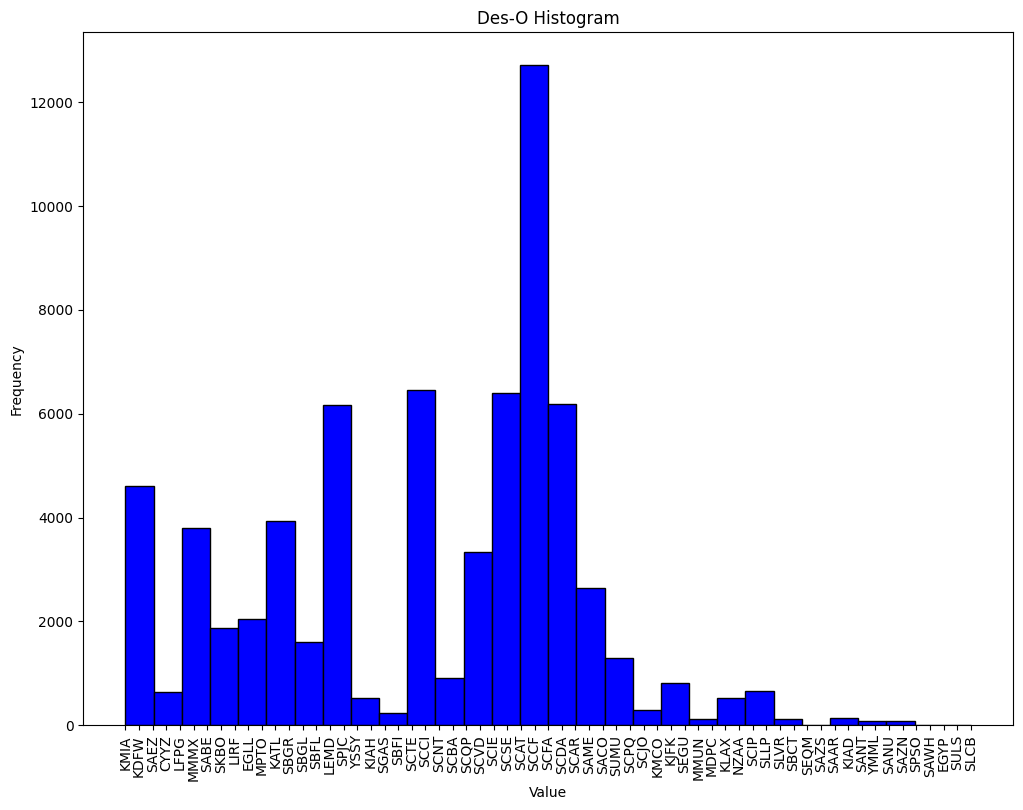

In [9]:
plt.figure(figsize=(12, 9))
plt.hist(df['Des-O'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Des-O Histogram')
plt.xticks(rotation=90)
plt.show()

In [10]:
top_10_destinations = df.value_counts('Des-O').reset_index().sort_values('count', ascending=False).head(10)
top_10_destinations.merge(df[['Des-O','SIGLADES']]).drop_duplicates()

,Des-O,count,SIGLADES
0,SCFA,5786,Antofagasta
5786,SPJC,5270,Lima
11056,SCCF,5146,Calama
16202,SCTE,4357,Puerto Montt
20559,SCIE,3993,Concepcion
24552,SCDA,3747,Iquique
28299,SBGR,3569,Sao Paulo
31868,SAEZ,3241,Buenos Aires
35109,SABE,3094,Buenos Aires
38203,SCQP,2589,Temuco


Ahora el cruce de Des-O con SIGLADES si da 1-1. Por lo tanto, el campo SIGLADES es referente al destino operacional

In [11]:
df['SIGLADES'].nunique(), df['Des-O'].nunique()

(62, 63)

In [12]:
df[['Des-O','SIGLADES']].drop_duplicates().sort_values('Des-O').head(60)

,Des-O,SIGLADES
109,CYYZ,Toronto
461,EGLL,Londres
61213,EGYP,Puerto Stanley
653,KATL,Atlanta
48,KDFW,Dallas
39265,KIAD,Washington
865,KIAH,Houston
5034,KJFK,Nueva York
5183,KLAX,Los Angeles
4997,KMCO,Orlando


### Emp-O

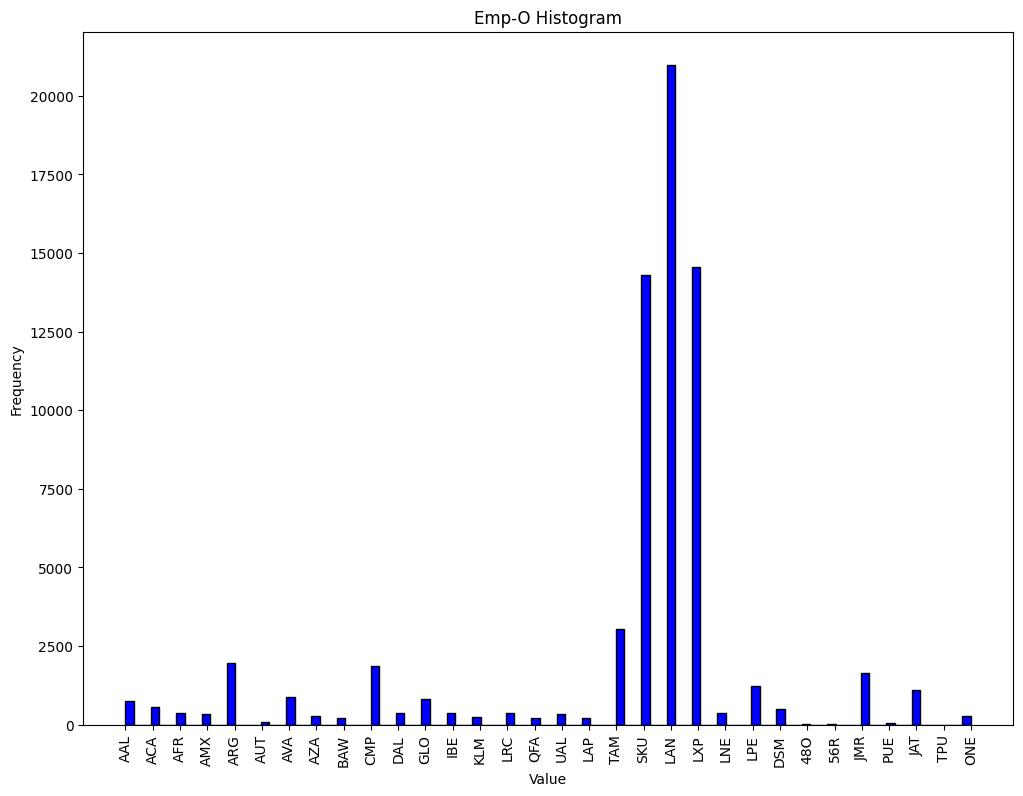

In [13]:
plt.figure(figsize=(12, 9))
plt.hist(df['Emp-O'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Emp-O Histogram')
plt.xticks(rotation=90)
plt.show()

La mayoría de los vuelos -O corresponden a la aerolinea LAN, SKU y LXP. Desde el -I (programado) al -O (operación) aparecieron muchos vuelos de LXP.

### MES

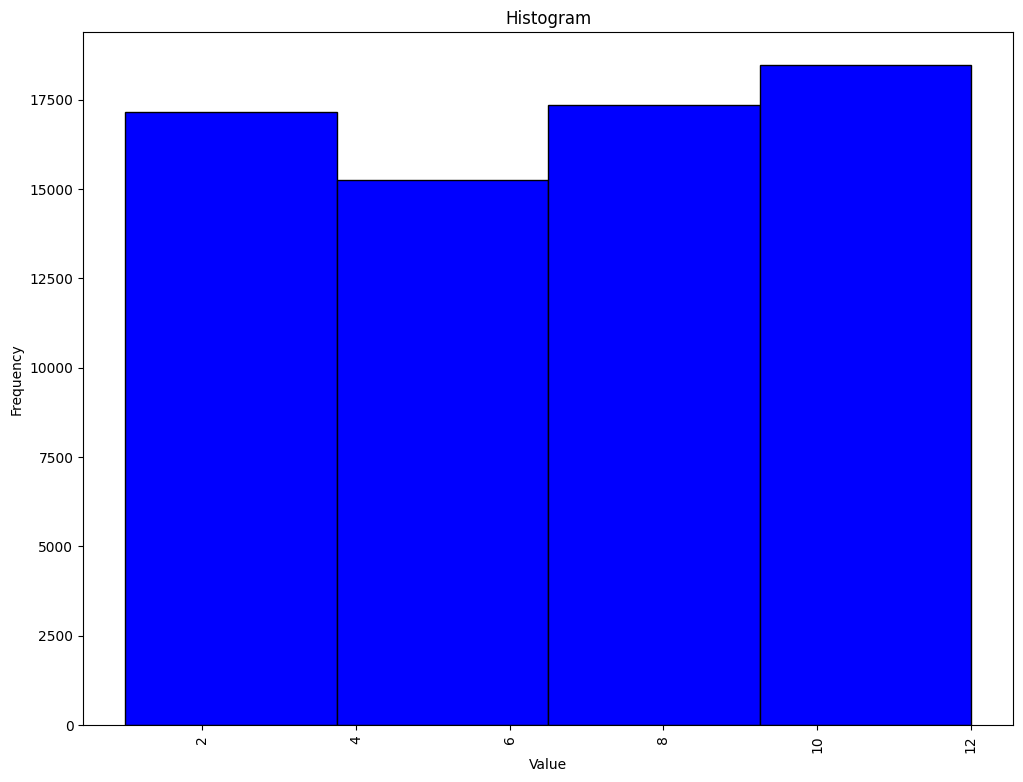

In [14]:
plt.figure(figsize=(12, 9))
plt.hist(df['MES'], bins=4, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

Si dividimos el año en trimestres, el segundo trimestre es el que tiene una menor cantidad de vuelos (temporada baja), mientras que el que más vuelos tienes es el cuarto trimestre (temporada alta)

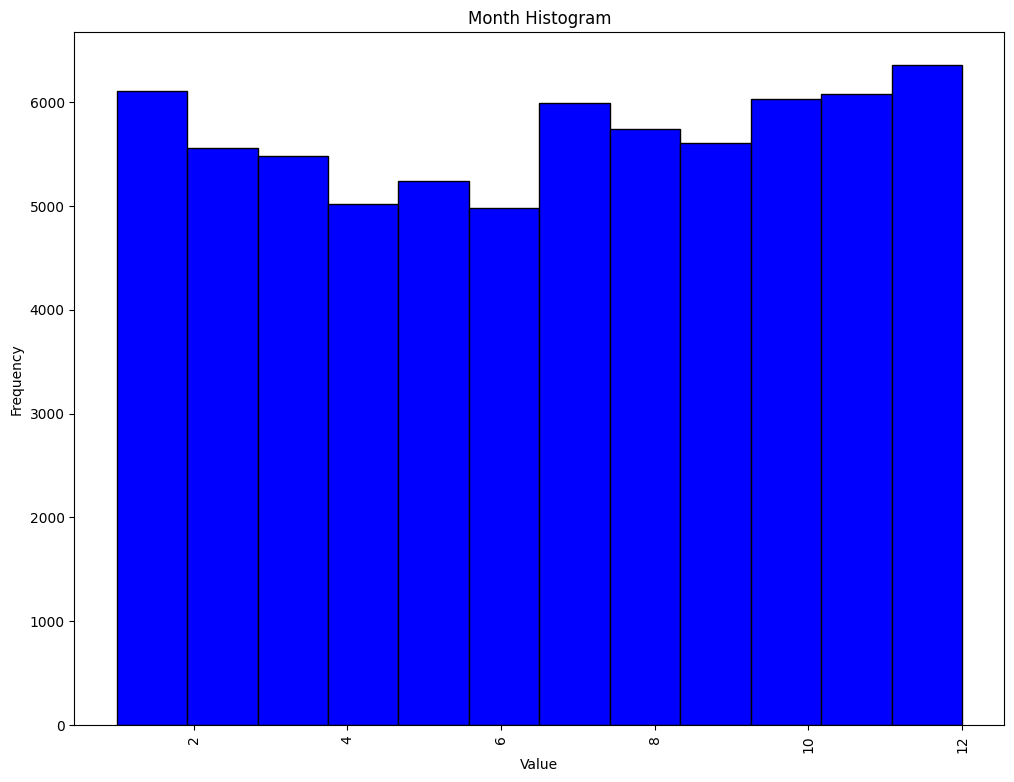

In [15]:
plt.figure(figsize=(12, 9))
plt.hist(df['MES'], bins=12, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Month Histogram')
plt.xticks(rotation=90)
plt.show()

Abril y junio son los meses con menos vuelos. Diciembre y enero los que tienen más vuelos.

### DIA

In [16]:
df.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


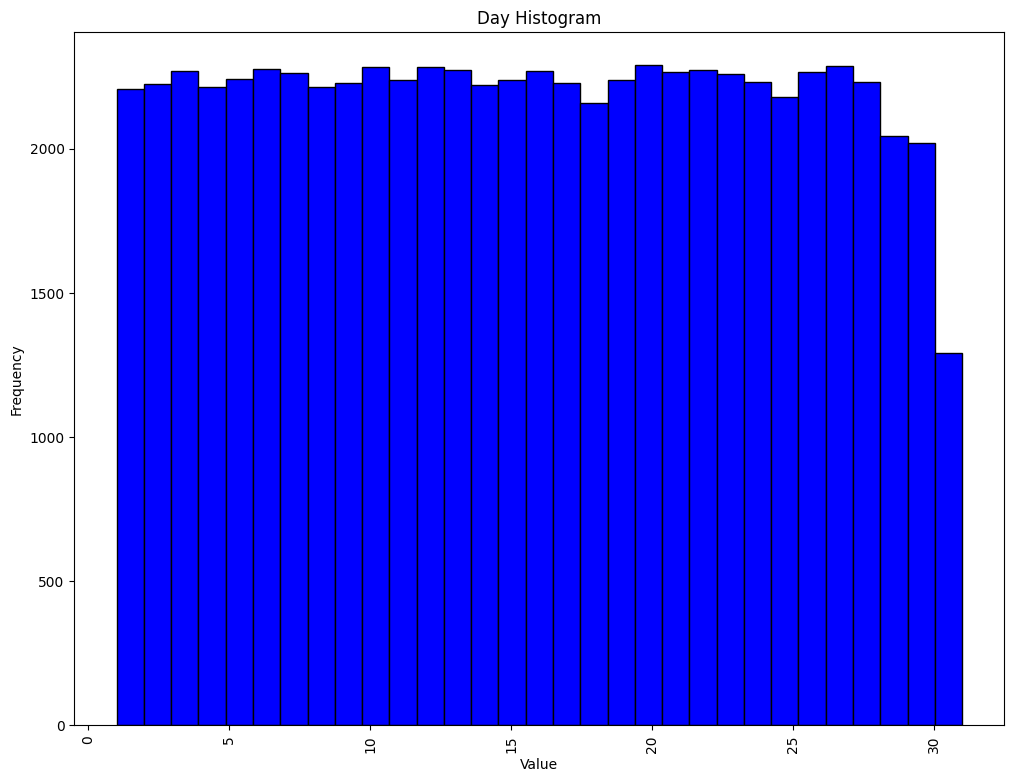

In [17]:
plt.figure(figsize=(12, 9))
plt.hist(df['DIA'], bins=31, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Day Histogram')
plt.xticks(rotation=90)
plt.show()

Sobre el día del mes, no parece haber algún día en el que predomine notoriamente la cantidad de vuelos por sobre los demás, salvo el día 31 que sucede porque la mitad de los meses tienen 31 días.

In [18]:
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [19]:
df['fecha_vuelo_O'] = df['Fecha-O'].apply(lambda x: x.date())
df['tiempo_vuelo_O'] = df['Fecha-O'].apply(lambda x: x.time())

In [20]:
flights_per_day = df['fecha_vuelo_O'].value_counts().reset_index()

In [21]:
flights_per_day['fecha_vuelo_O'] = pd.to_datetime(flights_per_day['fecha_vuelo_O'])

In [22]:
flights_per_day = flights_per_day.sort_values('fecha_vuelo_O')

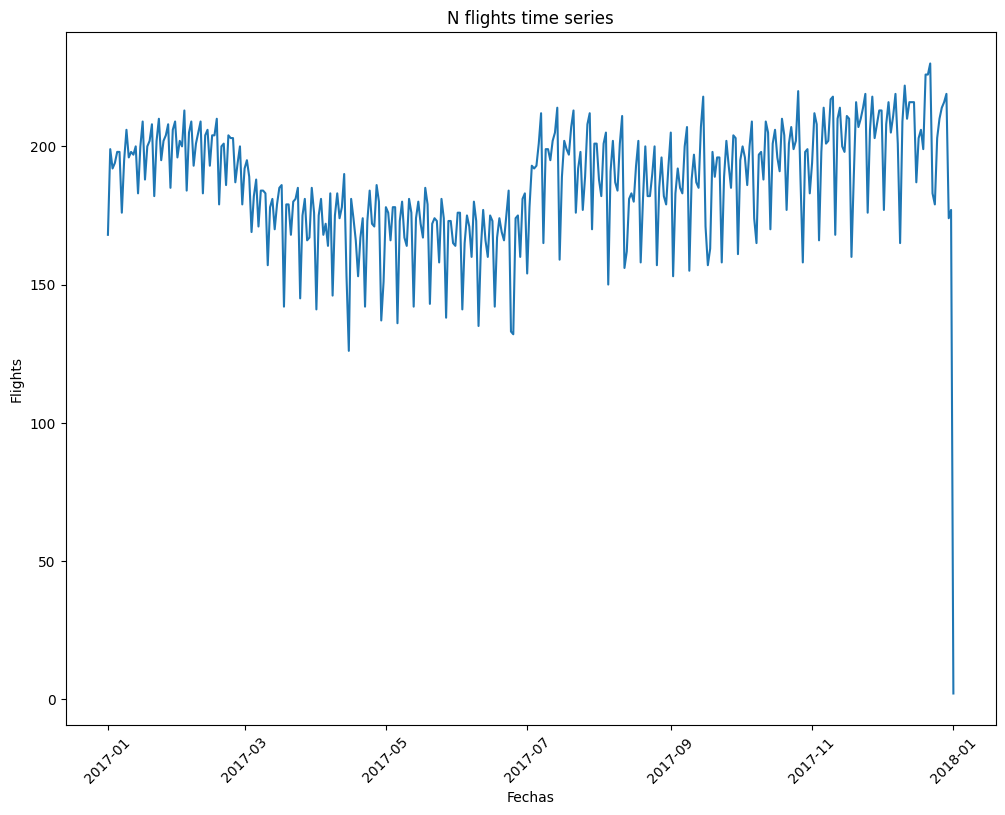

In [23]:
plt.figure(figsize=(12, 9))
plt.plot(pd.to_datetime(flights_per_day['fecha_vuelo_O']),flights_per_day['count'])
plt.xlabel('Fechas')
plt.ylabel('Flights')
plt.title('N flights time series')
plt.xticks(rotation=45)
plt.show()


Al graficar la cantidad de vuelos que se tienen de forma diaria, se puede apreciar el mismo efecto mensual (obviamente). Sin embargo, se pueden ver ciertos peaks negativos con una cierta frecuencia --> Efecto semanal, no todos los días son iguales.

### DIANOM

In [24]:
weekly_flights_total = df.value_counts('DIANOM').reset_index()
weekly_flights_total['index_day'] = np.where(
    weekly_flights_total.DIANOM == 'Lunes',
    1,
    np.where(
        weekly_flights_total.DIANOM == 'Martes',
        2,
        np.where(
            weekly_flights_total.DIANOM == 'Miercoles',
            3,
            np.where(
                weekly_flights_total.DIANOM == 'Jueves',
                4,
                np.where(
                    weekly_flights_total.DIANOM == 'Viernes',
                    5,
                    np.where(
                        weekly_flights_total.DIANOM == 'Sabado',
                        6,
                        7
                    )
                )
            )
        )
    )
)
weekly_flights_total = weekly_flights_total.sort_values('index_day')

In [25]:
weekly_flights_avg = df.groupby('DIANOM').DIA.count().reset_index()
total_weeks_per_year = df[['fecha_vuelo_O','DIANOM']].drop_duplicates().groupby('DIANOM').fecha_vuelo_O.count().reset_index()
weekly_flights_avg = weekly_flights_avg.merge(total_weeks_per_year)
weekly_flights_avg['avg_flights'] = weekly_flights_avg['DIA']/weekly_flights_avg['fecha_vuelo_O']
weekly_flights_avg['index_day'] = np.where(
    weekly_flights_avg.DIANOM == 'Lunes',
    1,
    np.where(
        weekly_flights_avg.DIANOM == 'Martes',
        2,
        np.where(
            weekly_flights_avg.DIANOM == 'Miercoles',
            3,
            np.where(
                weekly_flights_avg.DIANOM == 'Jueves',
                4,
                np.where(
                    weekly_flights_avg.DIANOM == 'Viernes',
                    5,
                    np.where(
                        weekly_flights_avg.DIANOM == 'Sabado',
                        6,
                        7
                    )
                )
            )
        )
    )
)

weekly_flights_avg = weekly_flights_avg.sort_values('index_day')

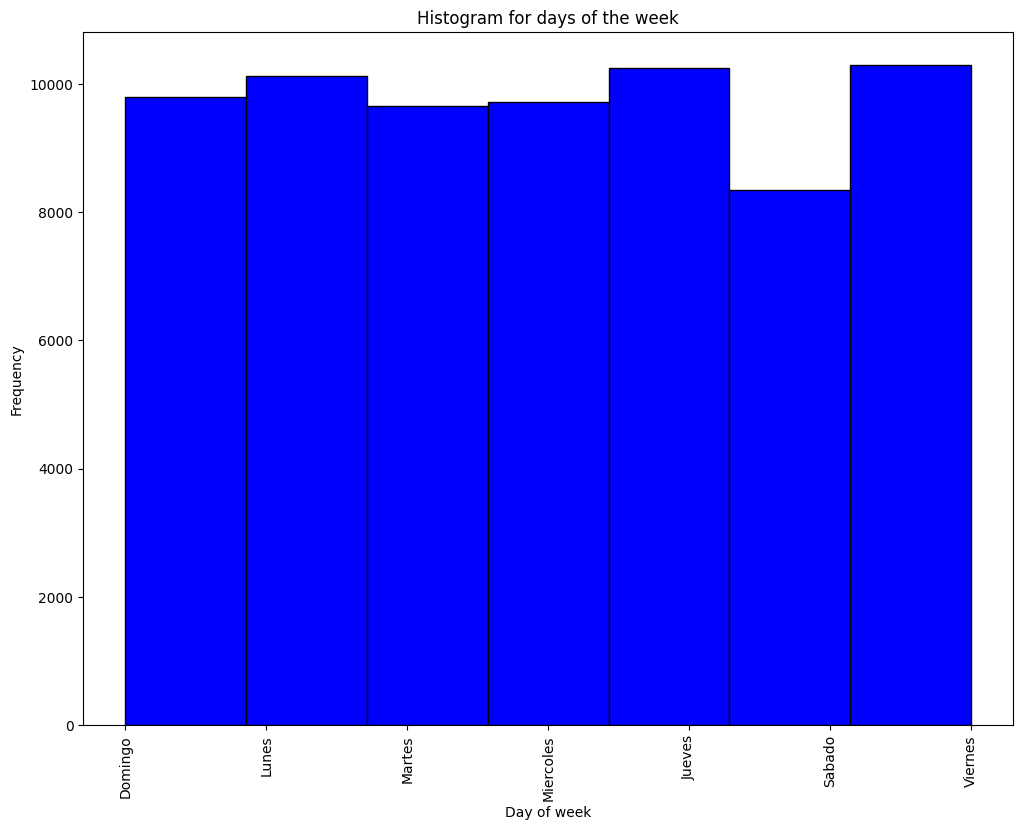

In [26]:
plt.figure(figsize=(12, 9))
plt.hist(df['DIANOM'], bins=7, color='blue', edgecolor='black')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.title('Histogram for days of the week')
plt.xticks(rotation=90)
plt.show()

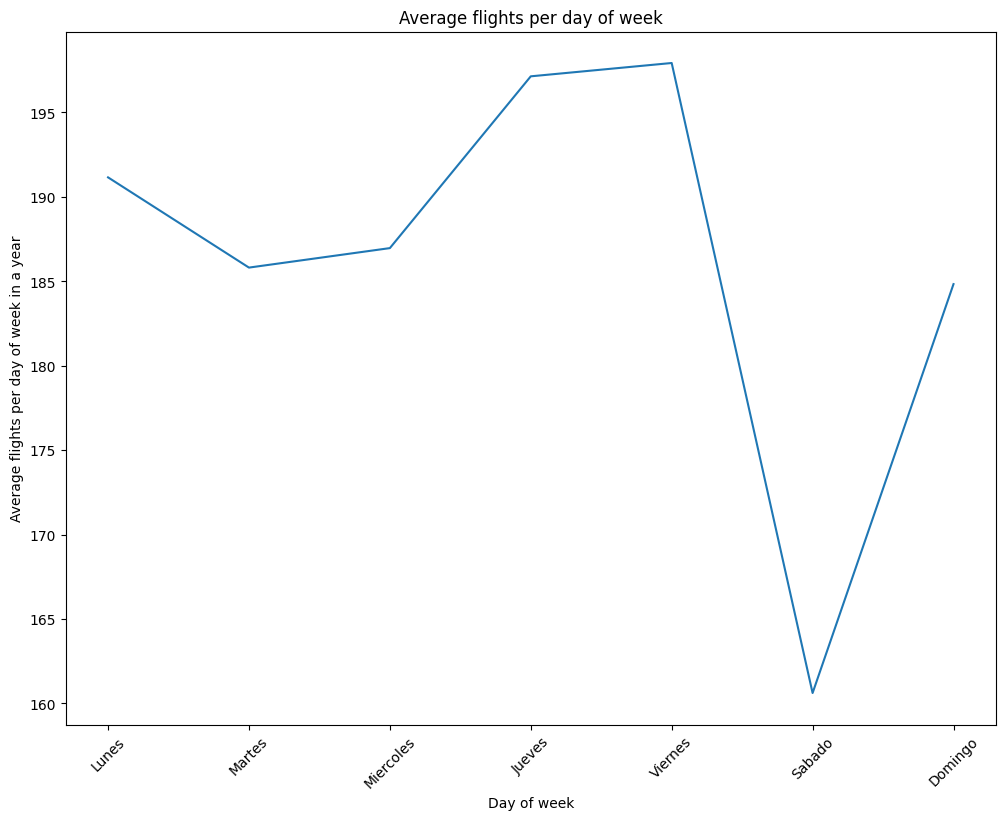

In [27]:
plt.figure(figsize=(12, 9))
plt.plot(weekly_flights_avg['DIANOM'], weekly_flights_avg['avg_flights'])
plt.xlabel('Day of week')
plt.ylabel('Average flights per day of week in a year')
plt.title('Average flights per day of week')
plt.xticks(rotation=45)
plt.show()


En los 2 gráficos mostrados podemos apreciar que tanto a nivel global, como a nivel promedio, el día sábado es el día en que menos vuelos salen, mientras que el día viernes es el día en que en promedio salen más vuelos durante el año.

### Hora

In [28]:
df['HORA'] = df['tiempo_vuelo_O'].apply(lambda x: x.hour)

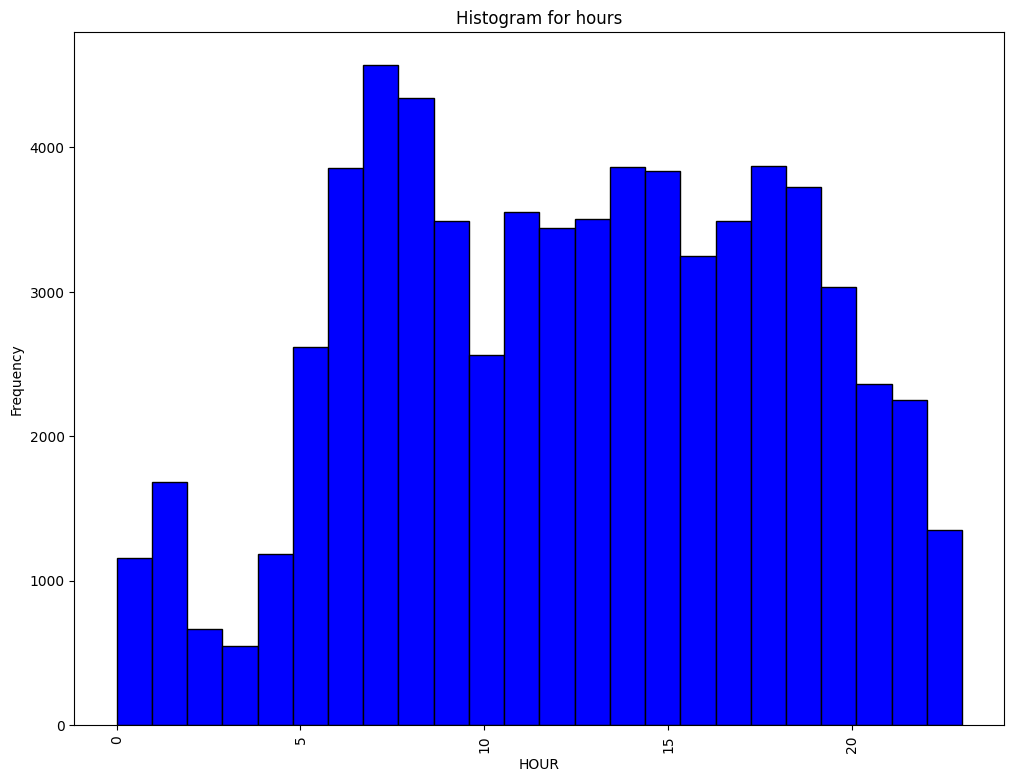

In [29]:
plt.figure(figsize=(12, 9))
plt.hist(df['HORA'], bins=24, color='blue', edgecolor='black')
plt.xlabel('HOUR')
plt.ylabel('Frequency')
plt.title('Histogram for hours')
plt.xticks(rotation=90)
plt.show()

In [30]:
hourly_flights = df.groupby('HORA').agg(distinct_count=('fecha_vuelo_O','nunique'), total=('DIA','count')).reset_index()
hourly_flights['mean_flights'] = hourly_flights['total']/hourly_flights['distinct_count']
hourly_flights

,HORA,distinct_count,total,mean_flights
0,0,333,1155,3.468468
1,1,363,1684,4.639118
2,2,314,665,2.117834
3,3,346,546,1.578035
4,4,352,1184,3.363636
5,5,364,2616,7.186813
6,6,365,3860,10.575342
7,7,365,4570,12.520548
8,8,365,4341,11.893151
9,9,365,3488,9.556164


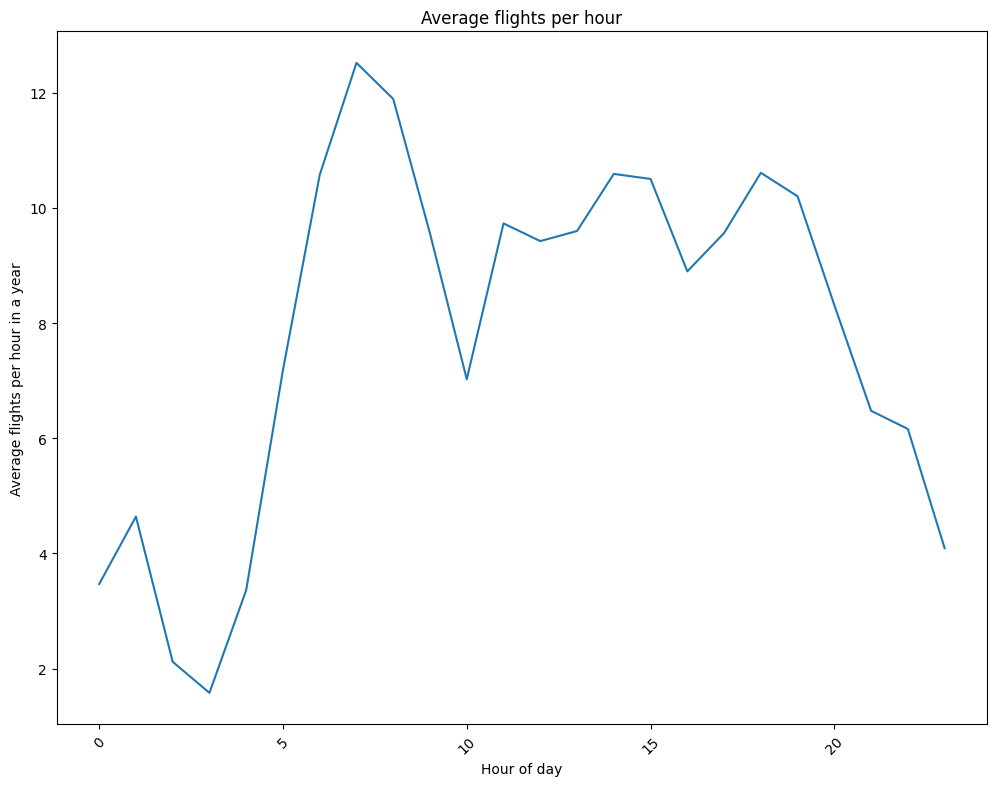

In [31]:
plt.figure(figsize=(12, 9))
plt.plot(hourly_flights['HORA'], hourly_flights['mean_flights'])
plt.xlabel('Hour of day')
plt.ylabel('Average flights per hour in a year')
plt.title('Average flights per hour')
plt.xticks(rotation=45)
plt.show()


Para el caso de las horas, tanto a nivel global como promedio la madrugada es en donde menos vuelos salen, mientras que en la mañana al rededor de las 7am es donde más vuelos salen.

### Tipo vuelo

<Axes: >

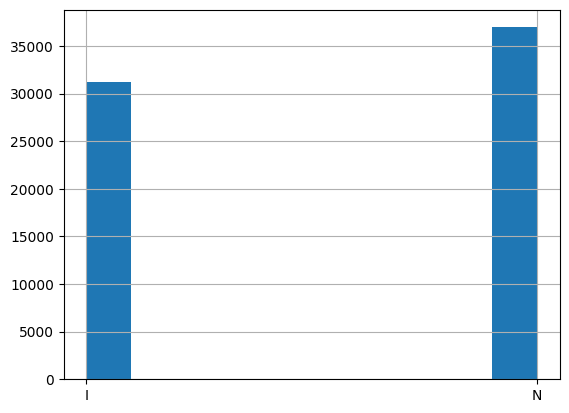

In [32]:
df.TIPOVUELO.hist()

In [33]:
df.groupby('TIPOVUELO').DIA.count()

TIPOVUELO
I    31240
N    36966
Name: DIA, dtype: int64

In [34]:
36966/(36966+31240)

0.5419757792569568

El 54% de los vuelos del 2017 fueron Nacionales

### Conclusiones sobre la distribuciones
Existen ciertas variables que son prácticamente constantes, es decir, no sirven para el entrenamiento del modelo (si en distintas condiciones se comporta de la misma forma no aporta información). Estas variables serían:
- El día del mes
- Data de origen programado
- Data de origen operacional

Por otro lado, las demás variables si tienen algunos valores que predominan. A continuación están los principales insights sobre las distribuciones:
- Hay ciertas ciudades (principalmente nacional) que son las que tienen una mayor frecuencia de destino.
- Existen ciertas aerolineas que acumulan la gran mayoría de los vuelos que salen de Santiago: LAN y SKU.
- Abril y junio son los meses con menos vuelos. Diciembre y enero los que tienen más vuelos.
- El día sábado es el día en que menos vuelos salen, mientras que el día viernes es el día en que en promedio salen más vuelos durante el año.
- La madrugada es en donde menos vuelos salen, mientras que en la mañana al rededor de las 7am es donde más vuelos salen.
- El 54% de los vuelos fueron Nacionales el 2017

## Validaciones varias

Apuntes sobre la data:
- Al parecer las features que tienen un -I son las que estaban programadas, y las features con un -O son lo que realmente sucedió
- Target: Fecha-O - Fecha-I --> Atraso (o adelanto). Acá se podría dar una cierta holgura de X minutos. Por definir.
- Vlo-I corresponde al número del vuelo. ¿La combinación de Origen-Destino-Horario hacen un número de vuelo? Validar
- Se tiene ciudad de origen y destino -O. ¿Esto quiere decir que las ciudades pueden ser distintas a lo que estaba programada? Sucede lo mismo con las aerolineas y el código del vuelo, pueden ser distintas a lo programado?
- Revisar si están bien los códigos con lo que realmente es --> validar con OPERA, SIGLAORI y SIGLADES.

In [35]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,fecha_vuelo_O,tiempo_vuelo_O,HORA
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,2017-01-01,23:33:00,23
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,2017-01-02,23:39:00,23
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Martes,I,American Airlines,Santiago,Miami,2017-01-03,23:39:00,23
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Miercoles,I,American Airlines,Santiago,Miami,2017-01-04,23:33:00,23
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,2017,Jueves,I,American Airlines,Santiago,Miami,2017-01-05,23:28:00,23


In [36]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['fecha_vuelo_I'] = df['Fecha-I'].apply(lambda x: x.date())
df['tiempo_vuelo_I'] = df['Fecha-I'].apply(lambda x: x.time())

In [37]:
df['Vlo-I'].nunique()

750

In [38]:
df[['Vlo-I','Ori-I','Des-I', 'Emp-I']].drop_duplicates().sort_values(['Emp-I','Vlo-I'])

,Vlo-I,Ori-I,Des-I,Emp-I
0,226,SCEL,KMIA,AAL
18,912,SCEL,KMIA,AAL
48,940,SCEL,KDFW,AAL
27464,940P,SCEL,KDFW,AAL
17206,9625,SCEL,KMIA,AAL
...,...,...,...,...
50837,9851,SCEL,SBGR,TAM
33676,9955,SCEL,SBGR,TAM
33670,9956,SCEL,SPJC,TAM
865,846,SCEL,KIAH,UAL


La combinación Origen, Destino, Fecha de salida no es necesariamente un número de vuelo. Para una misma aerolinea, mismo origen y mismo destino, y mismo número de vuelo, se tienen distintos horarios de salida.

In [39]:
destinations = df[['Des-I','Des-O']].drop_duplicates()
destinations['changed_from_I_to_O'] = np.where(destinations['Des-I']==destinations['Des-O'],0,1)
destinations

,Des-I,Des-O,changed_from_I_to_O
0,KMIA,KMIA,0
48,KDFW,KDFW,0
79,SAEZ,SAEZ,0
109,CYYZ,CYYZ,0
138,LFPG,LFPG,0
...,...,...,...
62651,YSSY,YMML,1
64297,SULS,SULS,0
67599,SAEZ,SABE,1
67692,SLCB,SLCB,0


In [40]:
destinations[destinations.changed_from_I_to_O==1]

,Des-I,Des-O,changed_from_I_to_O
1397,SCTE,SCQP,1
7520,SCIE,SCQP,1
12823,SCBA,SCTE,1
16169,KJFK,KMIA,1
16937,SEGU,SABE,1
20444,SCTE,SCCI,1
24569,SCFA,SCCF,1
33166,SBGR,SBGL,1
37162,SABE,SAEZ,1
39265,KIAH,KIAD,1


Hay 16 casos en los que el Destino programado fue distinto al Destino real. ¿Por qué sucede esto?
- Emergencias aereas, vuelos deben aterrizar en otro lugar.
- Error en la data

## Valores nulos

In [41]:
df.isna().sum()

Fecha-I           0
Vlo-I             0
Ori-I             0
Des-I             0
Emp-I             0
Fecha-O           0
Vlo-O             1
Ori-O             0
Des-O             0
Emp-O             0
DIA               0
MES               0
AÑO               0
DIANOM            0
TIPOVUELO         0
OPERA             0
SIGLAORI          0
SIGLADES          0
fecha_vuelo_O     0
tiempo_vuelo_O    0
HORA              0
fecha_vuelo_I     0
tiempo_vuelo_I    0
dtype: int64

No se tienen valores nulos

## Target

In [42]:
# Definir 4 variables: high_season, min_diff, delay_15 (target), period_day
# Subir nuevo df como csv al git

In [43]:
df['high_season'] = np.where(
    (
        ((df['Fecha-I'] >= datetime.datetime(2016,12,15)) & (df['Fecha-I'] <= datetime.datetime(2017,3,3)))
        |
        ((df['Fecha-I']>= datetime.datetime(2017,7,15)) & (df['Fecha-I'] <= datetime.datetime(2017,7,31)))
        |
        ((df['Fecha-I'] >= datetime.datetime(2017,9,11)) & (df['Fecha-I'] <= datetime.datetime(2017,9,30)))
        |
        ((df['Fecha-I'] >= datetime.datetime(2017,12,15)) & (df['Fecha-I'] <= datetime.datetime(2018,3,3)))
    ),
    1,
    0
)

In [44]:
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I'])

In [45]:
df['min_diff'] = df['min_diff'].apply(lambda x: x.total_seconds()/60)

<Axes: >

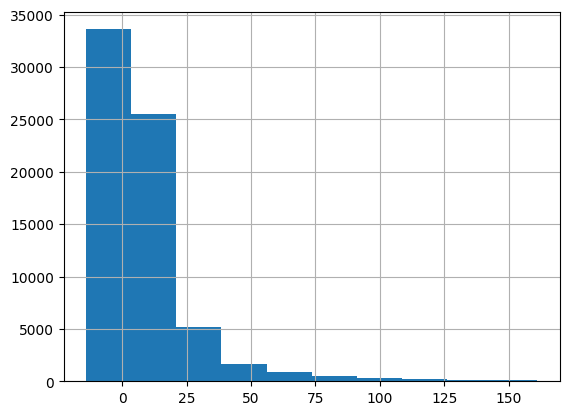

In [46]:
df.min_diff.hist()

In [47]:
df.min_diff.min(),df.min_diff.max() 

(-14.0, 161.0)

In [48]:
df['delay_15'] = np.where(df['min_diff']> 15,1,0)

In [49]:
df.value_counts('delay_15')

delay_15
0    55592
1    12614
Name: count, dtype: int64

Base altamente desbalanceada --> Se reduce la clase mayoritaria y se aumenta la clase minoritaria con SMOTE para que queden del mismo tamaño ambas clases.

In [50]:
df['period_day'] = np.where(
    df['tiempo_vuelo_I'].between(datetime.time(5,0),datetime.time(11,59)), 
    'morning',
    np.where(
        df['tiempo_vuelo_I'].between(datetime.time(12,0),datetime.time(18,59)),
        'afternoon',
        'night'
    )
)

In [51]:
df[df['period_day']=='morning'].tiempo_vuelo_I.min(),df[df['period_day']=='morning'].tiempo_vuelo_I.max()

(datetime.time(5, 0), datetime.time(11, 59))

In [52]:
df[df['period_day']=='morning'][['tiempo_vuelo_I']].drop_duplicates().sort_values('tiempo_vuelo_I')

,tiempo_vuelo_I
652,05:00:00
36824,05:02:00
65679,05:03:00
2944,05:05:00
55510,05:08:00
...,...
3171,11:55:00
42428,11:56:00
42010,11:57:00
35442,11:58:00


In [53]:
df[df['period_day']=='afternoon'].tiempo_vuelo_I.min(),df[df['period_day']=='afternoon'].tiempo_vuelo_I.max()

(datetime.time(12, 0), datetime.time(18, 59))

In [54]:
df[df['period_day']=='afternoon'][['tiempo_vuelo_I']].drop_duplicates().sort_values('tiempo_vuelo_I')

,tiempo_vuelo_I
1680,12:00:00
47597,12:01:00
38901,12:02:00
36579,12:03:00
12137,12:04:00
...,...
2000,18:55:00
35469,18:56:00
35756,18:57:00
44077,18:58:00


In [55]:
df[df['period_day']=='night'].tiempo_vuelo_I.min(),df[df['period_day']=='night'].tiempo_vuelo_I.max()

(datetime.time(0, 0), datetime.time(23, 59))

In [56]:
df[df['period_day']=='night'][['tiempo_vuelo_I']].drop_duplicates().sort_values('tiempo_vuelo_I').iloc[300:360]

,tiempo_vuelo_I
36519,22:59:00
3842,23:00:00
58195,23:04:00
2605,23:05:00
52742,23:06:00
2606,23:10:00
52172,23:11:00
35541,23:12:00
4611,23:15:00
36232,23:16:00


In [57]:
df_aux = pd.read_csv('dataset_SCL.csv')
original_columns = list(df_aux.columns)

/var/folders/qw/7c7_xnp52774fbcz_h1twtt80000gn/T/ipykernel_84474/3596053551.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_aux = pd.read_csv('dataset_SCL.csv')


In [58]:
original_columns.append('high_season')
original_columns.append('min_diff')
original_columns.append('delay_15')
original_columns.append('period_day')

In [59]:
df[['high_season','min_diff','delay_15','period_day']].to_csv('synthetic_features.csv', index=False)

In [60]:
df[original_columns].to_csv('original_plus_synthetic_features.csv', index=False)

In [61]:
df.to_csv('total_features.csv',index=False)

## Comportamiento del Delay

### Destination

In [62]:
des_plan = df.groupby(['Des-I','delay_15']).DIA.count().reset_index()
des_plan = des_plan.pivot(index='Des-I',columns='delay_15', values='DIA').reset_index().rename(columns={0:'No atraso',1:'Atraso'})

In [63]:
des_plan = des_plan.fillna(0)

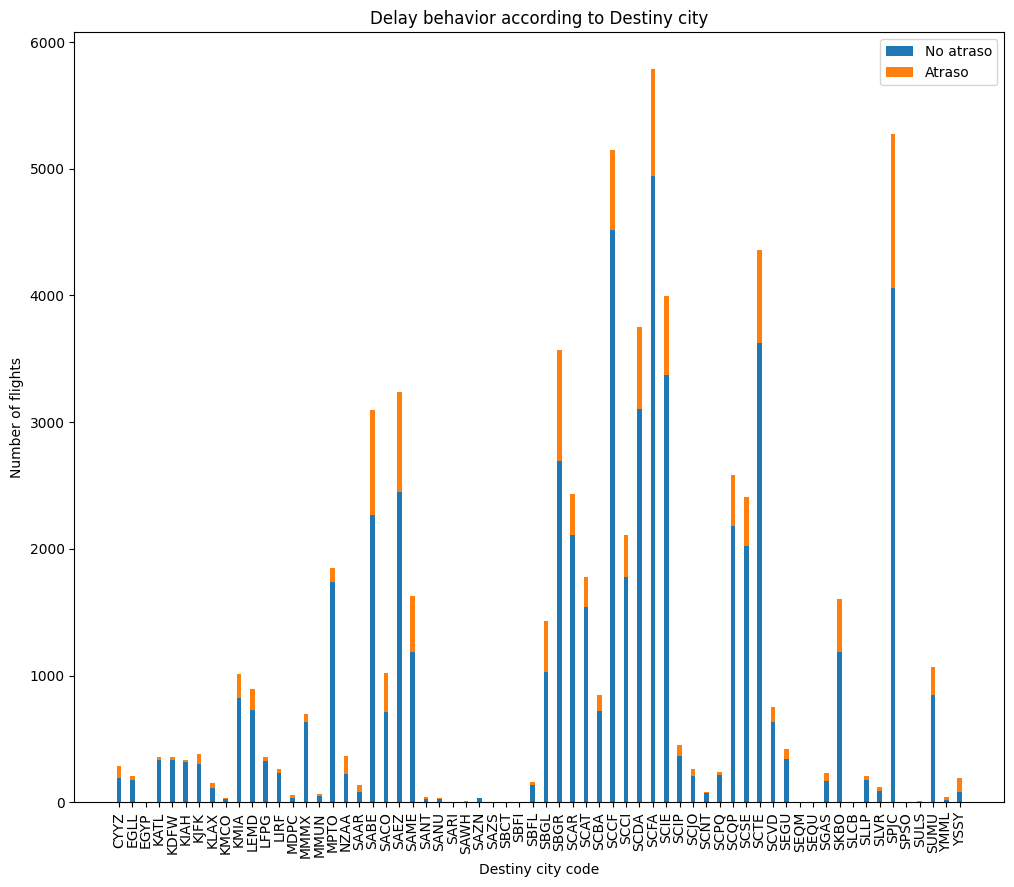

In [64]:
width = 0.35
plt.figure(figsize=(12, 10))
plt.bar(des_plan['Des-I'], des_plan['No atraso'], width, label='No atraso')
plt.bar(des_plan['Des-I'], des_plan['Atraso'], width, bottom=des_plan['No atraso'], label='Atraso')

plt.xlabel('Destiny city code')
plt.ylabel('Number of flights')
plt.title('Delay behavior according to Destiny city')
plt.xticks(rotation=90)
plt.legend()

plt.show()


In [65]:
des_plan['pct_atraso'] = des_plan['Atraso']/(des_plan['Atraso'] + des_plan['No atraso'])
des_plan['total_flights'] = des_plan['Atraso'] + des_plan['No atraso']

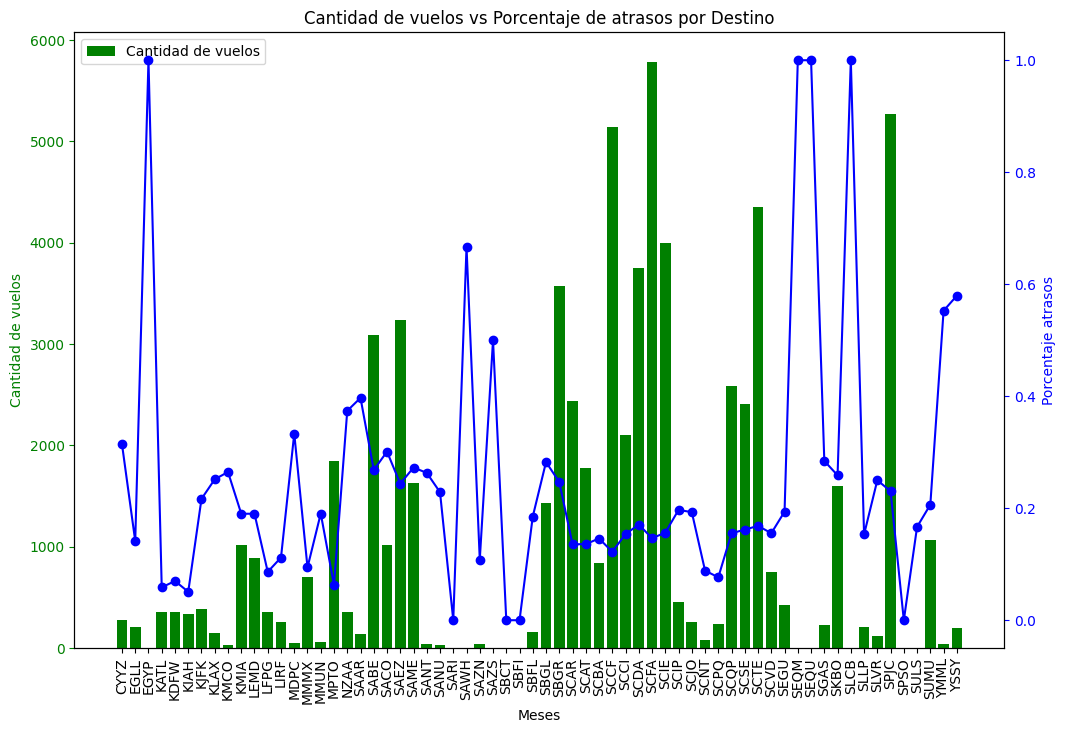

In [66]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(des_plan['Des-I'], des_plan['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
ax2.plot(des_plan['Des-I'], des_plan['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por Destino')

plt.show()


### A continuación tomamos un supuesto: las primeras 2 siglas del código de destino corresponden al país de destino

In [67]:
des_plan['country_code'] = des_plan['Des-I'].str[0:2]

In [68]:
des_plan

delay_15,Des-I,No atraso,Atraso,pct_atraso,total_flights,country_code
0,CYYZ,194.0,89.0,0.314488,283.0,CY
1,EGLL,176.0,29.0,0.141463,205.0,EG
2,EGYP,0.0,1.0,1.000000,1.0,EG
3,KATL,337.0,21.0,0.058659,358.0,KA
4,KDFW,332.0,25.0,0.070028,357.0,KD
...,...,...,...,...,...,...
59,SPSO,1.0,0.0,0.000000,1.0,SP
60,SULS,5.0,1.0,0.166667,6.0,SU
61,SUMU,846.0,220.0,0.206379,1066.0,SU
62,YMML,17.0,21.0,0.552632,38.0,YM


In [69]:
des_plan_country = des_plan.groupby('country_code').agg(no_atraso=('No atraso','sum'), atraso = ('Atraso','sum')).reset_index()
des_plan_country['pct_atraso'] = des_plan_country['atraso']/(des_plan_country['atraso']+ des_plan_country['no_atraso'])
des_plan_country['total_flights'] = des_plan_country['atraso']+ des_plan_country['no_atraso']
des_plan_country

,country_code,no_atraso,atraso,pct_atraso,total_flights
0,CY,194.0,89.0,0.314488,283.0
1,EG,176.0,30.0,0.145631,206.0
2,KA,337.0,21.0,0.058659,358.0
3,KD,332.0,25.0,0.070028,357.0
4,KI,318.0,17.0,0.050746,335.0
5,KJ,300.0,83.0,0.216710,383.0
6,KL,116.0,39.0,0.251613,155.0
7,KM,847.0,202.0,0.192564,1049.0
8,LE,724.0,170.0,0.190157,894.0
9,LF,328.0,31.0,0.086351,359.0


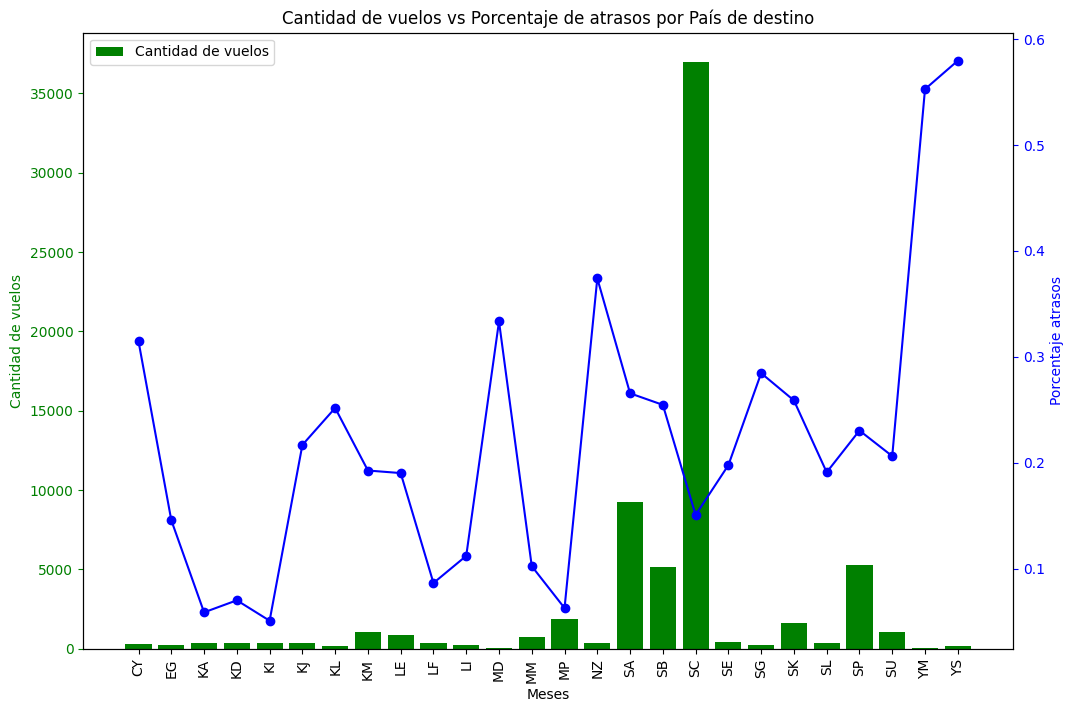

In [70]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(des_plan_country['country_code'], des_plan_country['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
ax2.plot(des_plan_country['country_code'], des_plan_country['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por País de destino')

plt.show()


- **Existen destinos que siempre se atrasan**
- En la mayoria de los destinos, el 20% de los vuelos se atraso aprox.
- **Existen países de destino en donde más de la mitad de los vuelos se atrasa**

### Airline

In [71]:
airlines = df.groupby(['Emp-I','delay_15']).DIA.count().reset_index()
airlines = airlines.pivot(index='Emp-I',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
airlines = airlines.fillna(0)
airlines

delay_15,Emp-I,no_atraso,atraso
0,AAL,706.0,51.0
1,ACA,307.0,258.0
2,AFR,328.0,30.0
3,AMX,341.0,10.0
4,ARG,1481.0,468.0
5,AUT,59.0,15.0
6,AVA,846.0,306.0
7,AZA,230.0,29.0
8,BAW,176.0,29.0
9,CMP,1734.0,116.0


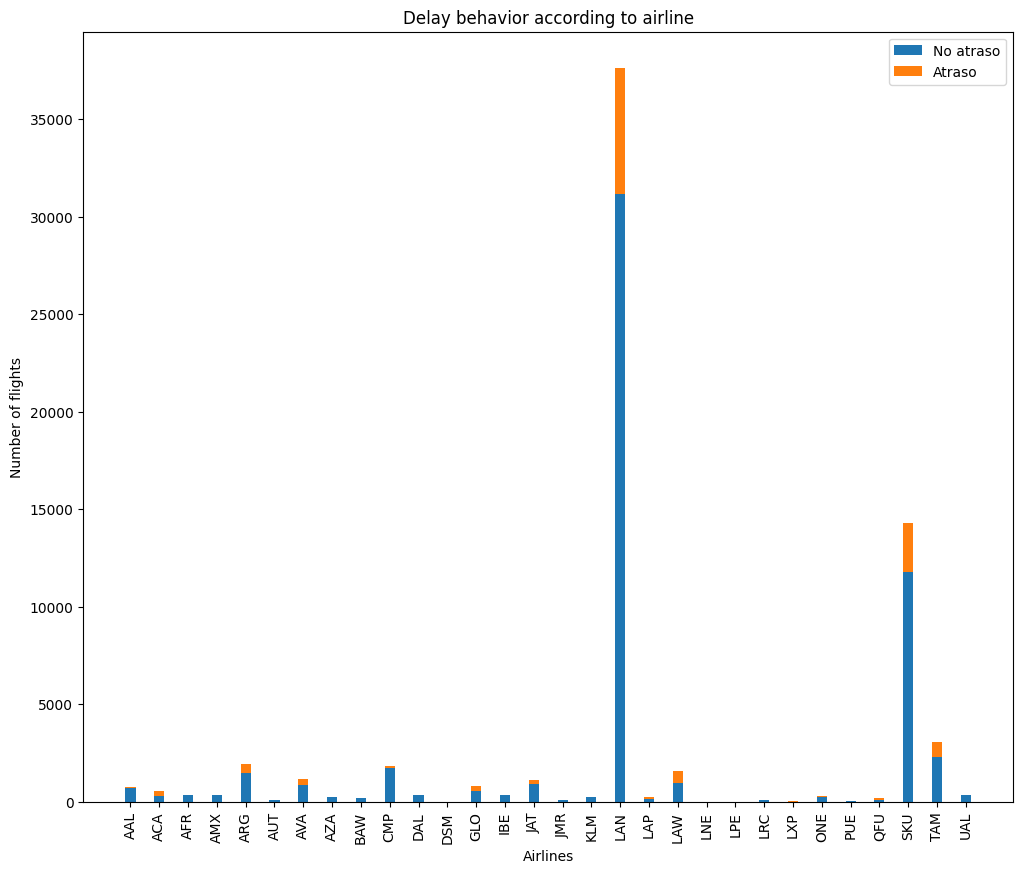

In [72]:
width = 0.35
plt.figure(figsize=(12, 10))
plt.bar(airlines['Emp-I'], airlines['no_atraso'], width, label='No atraso')
plt.bar(airlines['Emp-I'], airlines['atraso'], width, bottom=airlines['no_atraso'], label='Atraso')

plt.xlabel('Airlines')
plt.ylabel('Number of flights')
plt.title('Delay behavior according to airline')
plt.xticks(rotation=90)
plt.legend()

plt.show()


In [73]:
airlines['pct_atraso'] = airlines['atraso']/(airlines['atraso'] + airlines['no_atraso'])
airlines['total_flights'] = airlines['atraso'] + airlines['no_atraso']
airlines

delay_15,Emp-I,no_atraso,atraso,pct_atraso,total_flights
0,AAL,706.0,51.0,0.067371,757.0
1,ACA,307.0,258.0,0.456637,565.0
2,AFR,328.0,30.0,0.083799,358.0
3,AMX,341.0,10.0,0.028490,351.0
4,ARG,1481.0,468.0,0.240123,1949.0
5,AUT,59.0,15.0,0.202703,74.0
6,AVA,846.0,306.0,0.265625,1152.0
7,AZA,230.0,29.0,0.111969,259.0
8,BAW,176.0,29.0,0.141463,205.0
9,CMP,1734.0,116.0,0.062703,1850.0


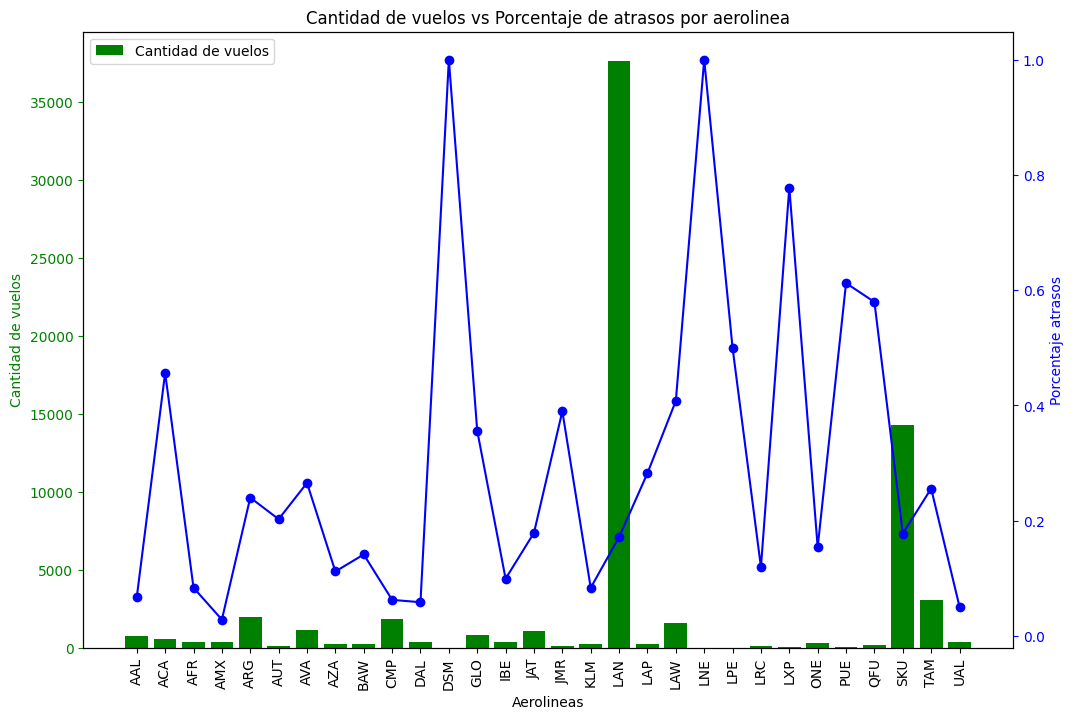

In [74]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(airlines['Emp-I'], airlines['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Aerolineas')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')
plt.xticks(rotation=90)

ax2 = ax1.twinx()
ax2.plot(airlines['Emp-I'], airlines['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por aerolinea')

plt.show()


- **Existen aerolineas que siempre se atrasan**, sin embargo, tienen pocos vuelos
- Las aerolineas con mayor cantidad de vuelos, se puede ver que tienen aproximadamente un 20% de atrasos en sus vuelos

### Month of the year

In [75]:
month_delay = df.groupby(['MES','delay_15']).DIA.count().reset_index()
month_delay = month_delay.pivot(index='MES',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
month_delay = month_delay.fillna(0)
month_delay['total_flights'] = month_delay['atraso'] + month_delay['no_atraso']
month_delay['pct_atraso'] = month_delay['atraso']/month_delay['total_flights']
month_delay['month_label'] = np.where(
    month_delay['MES'] == 1,
    'enero',
    np.where(
        month_delay['MES'] == 2,
        'febrero',
        np.where(
            month_delay['MES'] == 3,
            'marzo',
            np.where(
                month_delay['MES'] == 4,
                'abril',
                np.where(
                    month_delay['MES'] == 5,
                    'mayo',
                    np.where(
                        month_delay['MES'] == 6,
                        'junio',
                        np.where(
                            month_delay['MES'] == 7,
                            'julio',
                            np.where(
                                month_delay['MES'] == 8,
                                'agosto',
                                np.where(
                                    month_delay['MES'] == 9,
                                    'septiembre',
                                    np.where(
                                        month_delay['MES'] == 10,
                                        'octubre',
                                        np.where(
                                            month_delay['MES'] == 11,
                                            'noviembre',
                                            'diciembre'
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

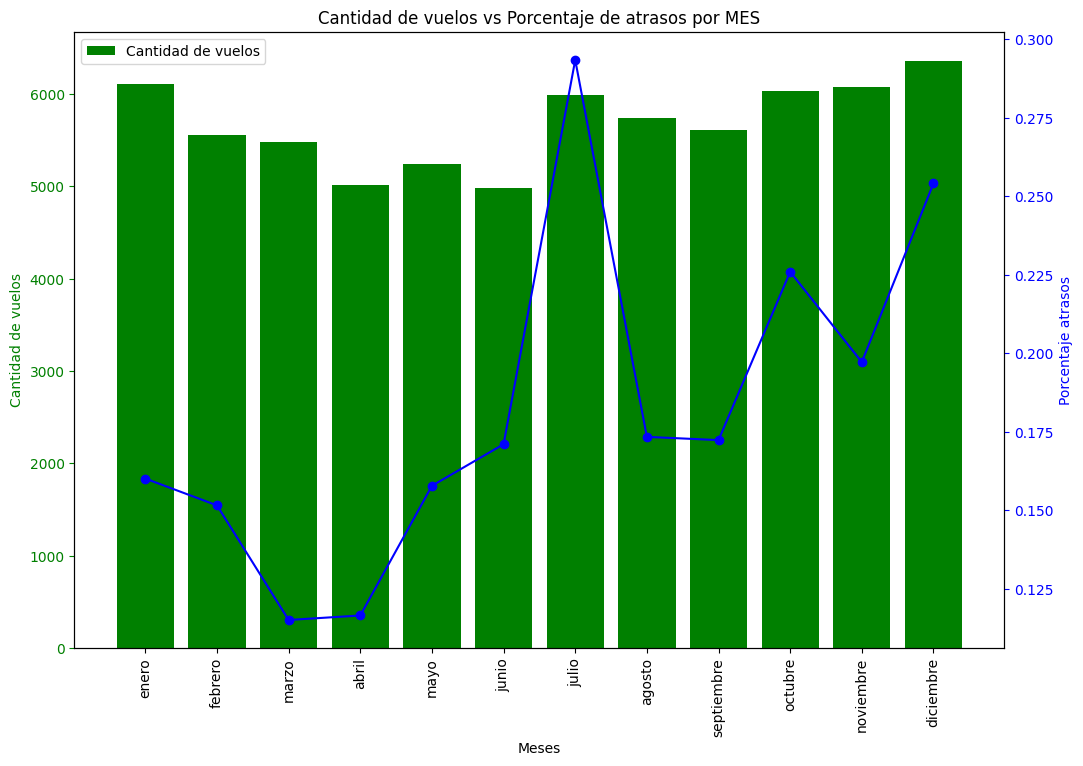

In [76]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(month_delay['month_label'], month_delay['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')
plt.xticks(rotation=90)

ax2 = ax1.twinx()
ax2.plot(month_delay['month_label'], month_delay['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por MES')

plt.show()


In [77]:
month_delay

delay_15,MES,no_atraso,atraso,total_flights,pct_atraso,month_label
0,1,5130,978,6108,0.160118,enero
1,2,4718,843,5561,0.151591,febrero
2,3,4851,631,5482,0.115104,marzo
3,4,4435,585,5020,0.116534,abril
4,5,4413,827,5240,0.157824,mayo
5,6,4129,852,4981,0.171050,junio
6,7,4234,1758,5992,0.293391,julio
7,8,4748,996,5744,0.173398,agosto
8,9,4643,967,5610,0.172371,septiembre
9,10,4669,1363,6032,0.225962,octubre


- **Julio es el mes con mayor porcentaje de atrasos, cercano a un 30%**
- Marzo y abril son los meses con menor porcentaje de atrasos, cercano a un 12%

### Day of the week

In [78]:
day_delay = df.groupby(['DIANOM','delay_15']).DIA.count().reset_index()
day_delay = day_delay.pivot(index='DIANOM',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
day_delay = day_delay.fillna(0)
day_delay['total_flights'] = day_delay['atraso'] + day_delay['no_atraso']
day_delay['pct_atraso'] = day_delay['atraso']/day_delay['total_flights']
day_delay['day_index'] = np.where(
    day_delay['DIANOM'] == 'Lunes',
    1,
    np.where(
        day_delay['DIANOM'] == 'Martes',
        2,
        np.where(
            day_delay['DIANOM'] == 'Miercoles',
            3,
            np.where(
                day_delay['DIANOM'] == 'Jueves',
                4,
                np.where(
                    day_delay['DIANOM'] == 'Viernes',
                    5,
                    np.where(
                        day_delay['DIANOM'] == 'Sabado',
                        6,
                        7
                    )
                )
            )
        )
    )
)
day_delay = day_delay.sort_values('day_index')
day_delay

delay_15,DIANOM,no_atraso,atraso,total_flights,pct_atraso,day_index
2,Lunes,8083,2048,10131,0.202152,1
3,Martes,8028,1634,9662,0.169116,2
4,Miercoles,8061,1661,9722,0.170850,3
1,Jueves,8206,2045,10251,0.199493,4
6,Viernes,8007,2285,10292,0.222017,5
5,Sabado,6989,1363,8352,0.163194,6
0,Domingo,8218,1578,9796,0.161086,7


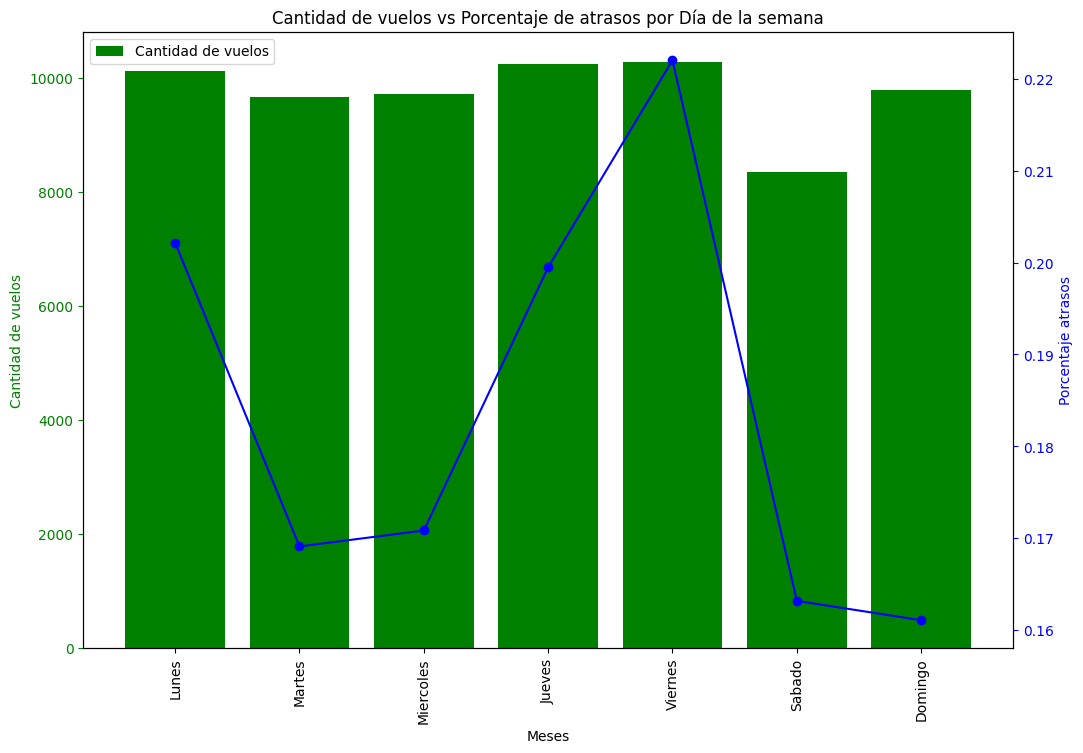

In [79]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(day_delay['DIANOM'], day_delay['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')
plt.xticks(rotation=90)

ax2 = ax1.twinx()
ax2.plot(day_delay['DIANOM'], day_delay['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por Día de la semana')

plt.show()


- **Los lunes y viernes son los días con más atrasos, por sobre un 20%**

### Season

In [80]:
season_delay = df.groupby(['high_season','delay_15']).DIA.count().reset_index()
season_delay = season_delay.pivot(index='high_season',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
season_delay = season_delay.fillna(0)
season_delay['total_flights'] = season_delay['atraso'] + season_delay['no_atraso']
season_delay['pct_atraso'] = season_delay['atraso']/season_delay['total_flights']
season_delay['season_desc'] = np.where(season_delay['high_season']== 1, 'temporada_alta','temporada_baja')

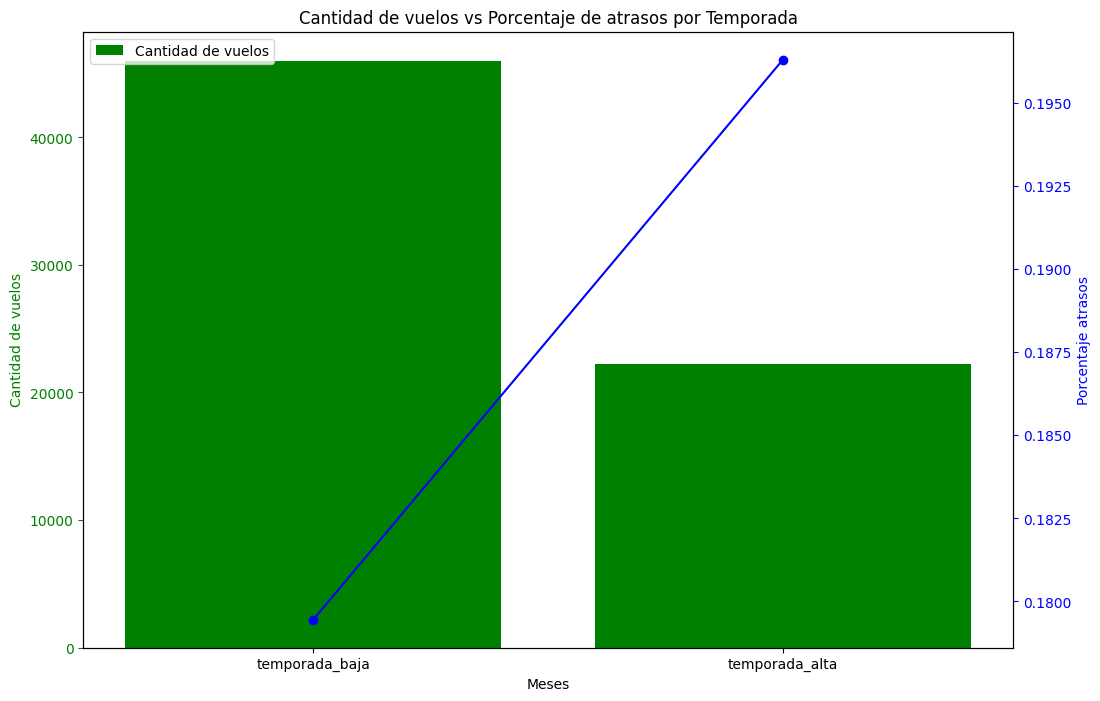

In [81]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(season_delay['season_desc'], season_delay['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')

ax2 = ax1.twinx()
ax2.plot(season_delay['season_desc'], season_delay['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por Temporada')

plt.show()


- Hay más vuelos en temporada baja
- Hay más atrasos en temporada alta, pero no es muy grande la diferencia, 1.5 puntos porcentuales más (8% más)

### Type of flight

In [82]:
type_delay = df.groupby(['TIPOVUELO','delay_15']).DIA.count().reset_index()
type_delay = type_delay.pivot(index='TIPOVUELO',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
type_delay = type_delay.fillna(0)
type_delay['total_flights'] = type_delay['atraso'] + type_delay['no_atraso']
type_delay['pct_atraso'] = type_delay['atraso']/type_delay['total_flights']
type_delay['type_desc'] = np.where(type_delay['TIPOVUELO']== 'I', 'INTERNACIONAL','NACIONAL')

In [83]:
type_delay

delay_15,TIPOVUELO,no_atraso,atraso,total_flights,pct_atraso,type_desc
0,I,24192,7048,31240,0.225608,INTERNACIONAL
1,N,31400,5566,36966,0.150571,NACIONAL


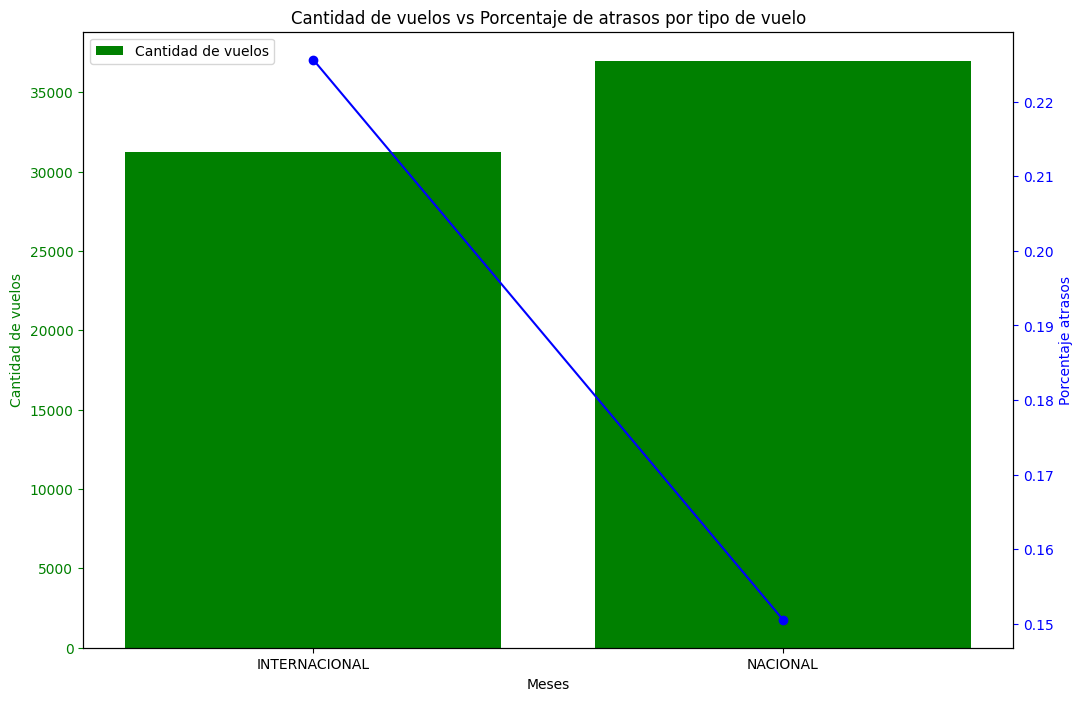

In [84]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(type_delay['type_desc'], type_delay['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')

ax2 = ax1.twinx()
ax2.plot(type_delay['type_desc'], type_delay['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por tipo de vuelo')

plt.show()


- Hay más vuelos nacionales
- **Hay más atrasos en internacional. Ahora si notablemente más (46% más)**

### HORA

In [85]:
df['HORA'] = df['tiempo_vuelo_I'].apply(lambda x: x.hour)

In [86]:
hour_delay = df.groupby(['HORA','delay_15']).DIA.count().reset_index()
hour_delay = hour_delay.pivot(index='HORA',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
hour_delay = hour_delay.fillna(0)
hour_delay['total_flights'] = hour_delay['atraso'] + hour_delay['no_atraso']
hour_delay['pct_atraso'] = hour_delay['atraso']/hour_delay['total_flights']
hour_delay

delay_15,HORA,no_atraso,atraso,total_flights,pct_atraso
0,0,822,260,1082,0.240296
1,1,1349,224,1573,0.142403
2,2,498,143,641,0.223089
3,3,461,44,505,0.087129
4,4,948,144,1092,0.131868
5,5,2225,289,2514,0.114956
6,6,3712,487,4199,0.115980
7,7,4130,752,4882,0.154035
8,8,3540,823,4363,0.188632
9,9,2672,592,3264,0.181373


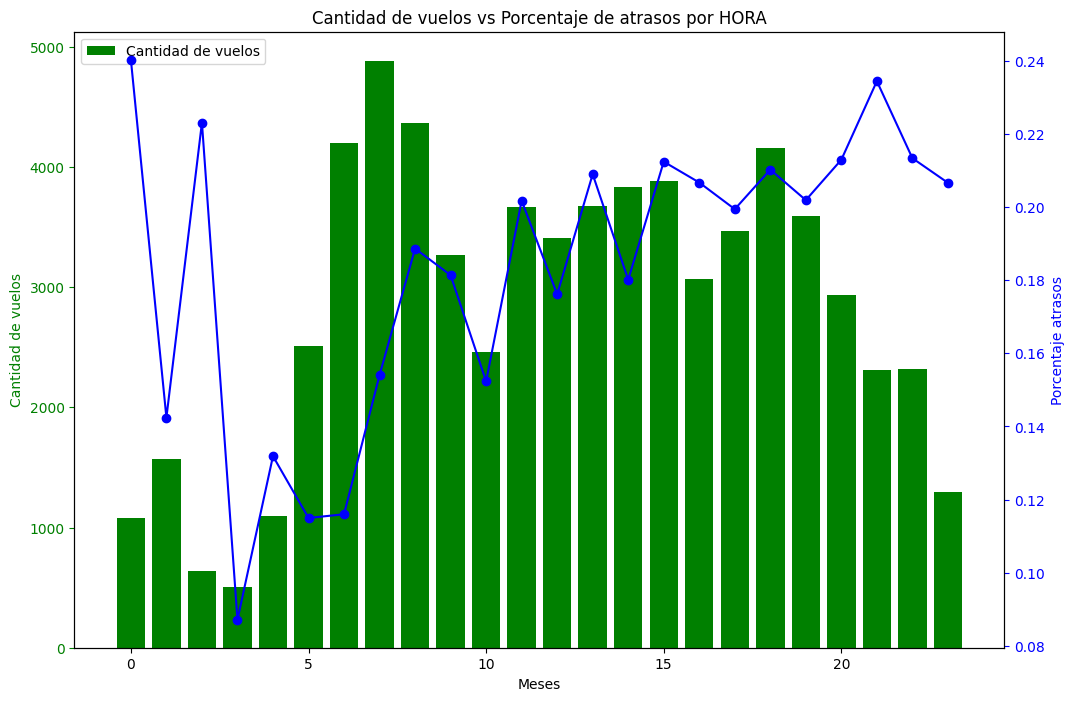

In [87]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(hour_delay['HORA'], hour_delay['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')

ax2 = ax1.twinx()
ax2.plot(hour_delay['HORA'], hour_delay['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por HORA')

plt.show()


- A medida que aumentan las horas del día, aumenta el porcentaje de atraso

### Periodo del día

In [88]:
period_delay = df.groupby(['period_day','delay_15']).DIA.count().reset_index()
period_delay = period_delay.pivot(index='period_day',columns='delay_15', values='DIA').reset_index().rename(columns={0:'no_atraso',1:'atraso'})
period_delay = period_delay.fillna(0)
period_delay['total_flights'] = period_delay['atraso'] + period_delay['no_atraso']
period_delay['pct_atraso'] = period_delay['atraso']/period_delay['total_flights']
period_delay

delay_15,period_day,no_atraso,atraso,total_flights,pct_atraso
0,afternoon,20420,5086,25506,0.199404
1,morning,21294,4058,25352,0.160066
2,night,13878,3470,17348,0.200023


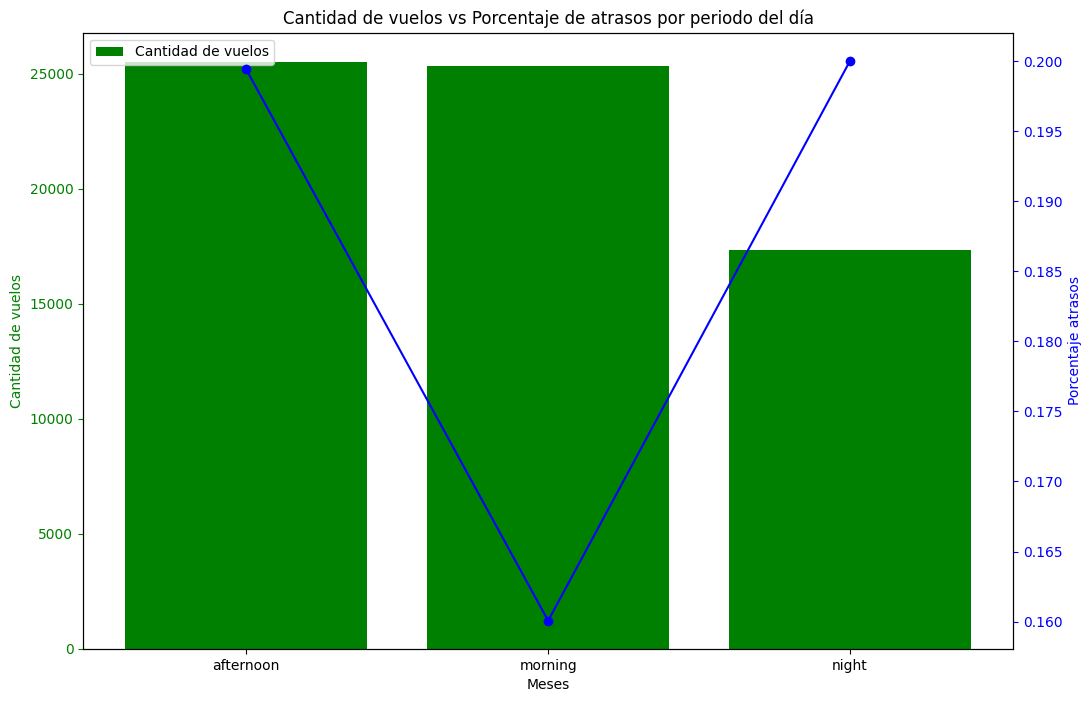

In [89]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(period_delay['period_day'], period_delay['total_flights'], color='green', label='Cantidad de vuelos')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Cantidad de vuelos', color='green')
ax1.tick_params('y', colors='green')

ax2 = ax1.twinx()
ax2.plot(period_delay['period_day'], period_delay['pct_atraso'], color='blue', marker='o', linestyle='-', label='Porcentaje de atrasos')
ax2.set_ylabel('Porcentaje atrasos', color='blue')
ax2.tick_params('y', colors='blue')

ax1.legend(loc='upper left')
plt.title('Cantidad de vuelos vs Porcentaje de atrasos por periodo del día')

plt.show()


- Similar a las horas del día, en la noche es donde más atrasos se tienen porcentualmente

### Conclusiones

De todos los gráficos vistos anteriormente podemos rescatar los siguientes insights:
- **Existen destinos que siempre se atrasan**
- **Existen países de destino en donde más de la mitad de los vuelos se atrasa**
- **Existen aerolineas que siempre se atrasan**, sin embargo, tienen pocos vuelos
- **Julio es el mes con mayor porcentaje de atrasos, cercano a un 30%**
- **Los lunes y viernes son los días con más atrasos, por sobre un 20%**
- La temporada parece no ser un factor diferenciador en los atrasos de los vuelos
- **Hay más atrasos en internacional. Ahora si notablemente más (46% más)**
- A medida que aumentan las horas del día, aumenta el porcentaje de atraso
- Similar a las horas del día, en la noche es donde más atrasos se tienen porcentualmente

Por lo tanto, en casi todas las variables vistas (excepto la temporada) se pueden encontrar distintos efectos sobre la variable target.

De todo lo anterior, las variables que a priori se ve que tengan un mayor impacto serían el mes y el día de la semana. En primera instancia parecía que el Destino, tanto a nivel ciudad como a nivel país podría indicar algo, ya que habían códigos que tenían 100% de atrasos, pero estos al tener tan poca cantidad de vuelos no va a pesar en la mayoría de los casos. Lo que si va a pasar es que va a sobreajustar esos casos y siempre que haya un vuelo con destino a una ciudad que tuvo 100% de atraso, lo va a calificar como potencial atraso.

# Entrenamiento

En primer lugar, se consideran sólo las variables de Planificación (-I), no las operacionales, ya que estás las sabremos cuando ya haya ocurrido el vuelo (ex post). Las demás variables, se consideraran todas, pero transformadas en categóricas con one hot encoding. De esta manera nuestras features serán todas binarias.

Debido a esto, se entrenara con modelos de tipo arbol como Random Forest y XGBoost. También se entrenará con Naive Bayes y SVM para comparar resultados.

In [90]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'fecha_vuelo_O', 'tiempo_vuelo_O',
       'HORA', 'fecha_vuelo_I', 'tiempo_vuelo_I', 'high_season', 'min_diff',
       'delay_15', 'period_day'],
      dtype='object')

## Preprocesamiento

In [91]:
df['minutes'] = df['tiempo_vuelo_I'].apply(lambda x: x.minute)

### One hot encoding

In [92]:
train_data = df[['Des-I','Emp-I','DIA','MES','DIANOM','TIPOVUELO','high_season','period_day','minutes','delay_15']].reset_index(drop=True).reset_index()
train_data.rename(columns={
    'index':'idx',
    'Des-I':'destiny_city_cd',
    'Emp-I':'airline_cd',
    'DIA':'day_of_month',
    'MES': 'month_of_year',
    'DIANOM':'weekday_name',
    'TIPOVUELO':'flight_type',
    'minutes':'minutes_from_hour'
}, inplace=True)
train_data['country_cd'] = train_data['destiny_city_cd'].str[0:2]
final_one_hot = pd.DataFrame()
for var in train_data.columns:
    if ((var == 'idx') | (var == 'delay_15')):
        pass
    else:
        _ = train_data.groupby(['idx',var], dropna=False).delay_15.count().reset_index()
        _ = _.pivot_table(columns=var,index=['idx'],values='delay_15').reset_index().fillna(0)
        _.columns = [
            (str(var).lower() + '_' + str(x).upper()).replace(" ","_").strip() 
            if x not in ['idx'] else x for x in _.columns]
        
        if len(final_one_hot) == 0:
            final_one_hot = _.copy()
        else:
            final_one_hot = final_one_hot.merge(
                _, how='outer', on=['idx']
            )
final_train_data = train_data[['idx','delay_15']].merge(final_one_hot, on = ['idx'])

In [93]:
final_train_data

,idx,delay_15,destiny_city_cd_CYYZ,destiny_city_cd_EGLL,destiny_city_cd_EGYP,destiny_city_cd_KATL,destiny_city_cd_KDFW,destiny_city_cd_KIAH,destiny_city_cd_KJFK,destiny_city_cd_KLAX,...,country_cd_SB,country_cd_SC,country_cd_SE,country_cd_SG,country_cd_SK,country_cd_SL,country_cd_SP,country_cd_SU,country_cd_YM,country_cd_YS
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,68201,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68202,68202,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68203,68203,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68204,68204,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Balanceo target

In [94]:
final_train_data.delay_15.value_counts()

delay_15
0    55592
1    12614
Name: count, dtype: int64

Base altamente desbalanceada:
- La clase mayoritaria se reduce de 55.592 vuelos sin atraso a 30.000 vuelos sin atraso, de forma aleatoria
- La clase minoritaria se aumenta con SMOTE de 12.614 vuelos con atraso a 30.000 vuelos con atraso.

In [95]:
balanced_train = final_train_data.copy()
balanced_train = balanced_train.loc[:,balanced_train.columns!='idx']
balanced_data_atraso = balanced_train[balanced_train.delay_15==1]
balanced_data_no_atraso = balanced_train[balanced_train.delay_15==0]

In [96]:
balanced_data_no_atraso = balanced_data_no_atraso.sample(n=30000)
balanced_train = pd.concat([balanced_data_atraso, balanced_data_no_atraso])

In [97]:
balanced_train = balanced_train.reset_index(drop=True).reset_index().rename(columns={'index':'idx'})
balanced_train = balanced_train.sort_values('idx')
y = balanced_train['delay_15'].values
balanced_train = balanced_train.set_index('idx')

In [98]:
X = balanced_train.loc[:,balanced_train.columns!='delay_15']

In [99]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X, y = sm.fit_resample(X, y.ravel())

In [100]:
X

,destiny_city_cd_CYYZ,destiny_city_cd_EGLL,destiny_city_cd_EGYP,destiny_city_cd_KATL,destiny_city_cd_KDFW,destiny_city_cd_KIAH,destiny_city_cd_KJFK,destiny_city_cd_KLAX,destiny_city_cd_KMCO,destiny_city_cd_KMIA,...,country_cd_SB,country_cd_SC,country_cd_SE,country_cd_SG,country_cd_SK,country_cd_SL,country_cd_SP,country_cd_SU,country_cd_YM,country_cd_YS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Entrenamiento

In [101]:
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, classification_report

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y)

In [103]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42000, 237), (42000,), (18000, 237), (18000,))

## NB

In [104]:
gnb = GaussianNB()

In [105]:
# grid of hyperparameters
param_grid = { 
    'var_smoothing': np.logspace(0,-9, num=100)
}

scoring = 'roc_auc'

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [106]:
random_search_NB = RandomizedSearchCV(
    estimator=gnb, 
    param_distributions=param_grid, 
    n_iter=100,
    scoring=scoring, 
    n_jobs=-1, 
    refit=False,
    cv=kfold, 
    verbose=10
)

In [107]:
random_result_NB = random_search_NB.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV 1/5; 1/100] START var_smoothing=1.0.........................................
[CV 2/5; 1/100] START var_smoothing=1.0.........................................
[CV 1/5; 1/100] END ..........var_smoothing=1.0;, score=0.643 total time=   0.4s
[CV 2/5; 1/100] END ..........var_smoothing=1.0;, score=0.643 total time=   0.4s
[CV 3/5; 1/100] START var_smoothing=1.0.........................................
[CV 4/5; 1/100] START var_smoothing=1.0.........................................
[CV 3/5; 1/100] END ..........var_smoothing=1.0;, score=0.638 total time=   0.3s
[CV 3/5; 2/100] START var_smoothing=0.8111308307896871..........................
[CV 5/5; 1/100] START var_smoothing=1.0.........................................
[CV 4/5; 1/100] END ..........var_smoothing=1.0;, score=0.643 total time=   0.4s
[CV 3/5; 2/100] END var_smoothing=0.8111308307896871;, score=0.642 total time=   0.3s
[CV 4/5; 2/100] START var_smoothing=0.8111308307896871..........................
[CV 5/5; 1/100] END ...

/Users/josecanto/opt/anaconda3/envs/test_latam/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5; 5/100] END var_smoothing=0.43287612810830584;, score=0.654 total time=   0.2s
[CV 4/5; 5/100] START var_smoothing=0.43287612810830584.........................
[CV 4/5; 5/100] END var_smoothing=0.43287612810830584;, score=0.657 total time=   0.2s
[CV 5/5; 5/100] START var_smoothing=0.43287612810830584.........................
[CV 1/5; 6/100] START var_smoothing=0.3511191734215131..........................
[CV 5/5; 5/100] END var_smoothing=0.43287612810830584;, score=0.650 total time=   0.2s
[CV 1/5; 6/100] END var_smoothing=0.3511191734215131;, score=0.662 total time=   0.2s
[CV 3/5; 6/100] START var_smoothing=0.3511191734215131..........................
[CV 4/5; 6/100] START var_smoothing=0.3511191734215131..........................
[CV 3/5; 6/100] END var_smoothing=0.3511191734215131;, score=0.657 total time=   0.2s
[CV 5/5; 6/100] START var_smoothing=0.3511191734215131..........................
[CV 4/5; 6/100] END var_smoothing=0.3511191734215131;, score=0.660 total time=   

In [108]:
best_params_nb = random_result_NB.best_params_
best_params_nb

{'var_smoothing': 0.1}

In [109]:
nb_model = GaussianNB(var_smoothing = random_result_NB.best_params_['var_smoothing'])
nb_model = nb_model.fit(X_train, y_train)

In [110]:
import pickle
pickle.dump(nb_model, open('nb_model.model', 'wb'))

## SVM

In [111]:
svc = SVC(probability=True)

In [112]:
# # Hyperparameter C
# C = np.logspace(-10,10,30)

# # Hyperparameter gamma
# gamma = np.logspace(-10,10,30)

# # Hyperparameter Kernel
# Kernel = ['rbf','poly','linear']

In [113]:
# # grid of hyperparameters
# param_grid = { 
#     "C": C,
#     "kernel": Kernel,
#     "gamma": gamma.tolist()+['scale', 'auto']
# }

# scoring = 'accuracy'

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [114]:
# random_search = RandomizedSearchCV(
#     estimator=svc, 
#     param_distributions=param_grid, 
#     n_iter=10,
#     scoring=scoring, 
#     n_jobs=-1, 
#     refit=True,
#     cv=kfold, 
#     verbose=10
# )

# random_result = random_search.fit(X_train, y_train)

# random_result

In [115]:
#svm_model = random_result.best_estimator_

In [116]:
# import pickle
# pickle.dump(svm_model, open('svm_model.model', 'wb'))

**Se demora demasiado SVM --> Se entrenara una versión simple sin optimización de hiperparámetros**

Optimización de hiperparámetros se demora mucho, se entrena modelo simple con hiperparámetros por defecto

In [117]:
svm_model = svc.fit(X_train, y_train)

In [118]:
import pickle
pickle.dump(svm_model, open('svm_model.model', 'wb'))

Versión "simple" se demoró 28 minutos en correr, sin ninguna optimización. Esto puede darse debido al tipo de datos que se están utilizando, que son únicamente variables categóricas, y SVM al ser un modelo lineal, no se lleva tan bien con este tipo de datos.

## Random Forest

In [112]:
rf = RandomForestClassifier()

In [113]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['log2', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

In [114]:
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [115]:
scoring = 'roc_auc'

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [123]:
random_search_rf = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=random_grid, 
    n_iter=50,
    scoring=scoring, 
    n_jobs=-1, 
    refit=True,
    cv=kfold, 
    verbose=2
)

random_result_rf = random_search_rf.fit(X_train, y_train)

random_result_rf

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.5min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.5min
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.7min
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.8min
[CV] END bootstrap=False, max_de

/Users/josecanto/opt/anaconda3/envs/env_latam/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.0min
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.0min
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 1.9min
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 1.9min
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.7min
[CV] END bootstrap=False, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.8min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.5min
[CV] END bootstrap=True, max_dept

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='roc_auc', verbose=2)

In [175]:
best_params_rf = random_result_rf.best_params_
best_params_rf

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': False}

In [124]:
rf_model = random_result_rf.best_estimator_

In [125]:
import pickle
pickle.dump(rf_model, open('rf_model.model', 'wb'))

## XGB

In [116]:
xgb_c = xgb.XGBClassifier()

In [117]:
learning_rate = [0.01,0.05,0.1,0.15,0.2,0.25,0.30]
gamma = [int(x) for x in np.linspace(1,20, num = 11)]
max_depth = [int(x) for x in np.linspace(1,20, num = 11)]
min_child_weight = [int(x) for x in np.linspace(1,30, num = 11)]
subsample = [x for x in np.linspace(0.5,1, num = 8)]
colsample_bytree = [x for x in np.linspace(0.5,1, num = 8)]
colsample_bylevel = [x for x in np.linspace(0.5,1, num = 8)]
reg_alpha = [x for x in np.linspace(0.01,10, num = 20)]

In [118]:
random_grid = {
    'learning_rate': learning_rate,
    'gamma': gamma,
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'colsample_bylevel': colsample_bylevel,
    'reg_alpha': reg_alpha
}

In [119]:
scoring = 'roc_auc'

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [130]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_c, 
    param_distributions=random_grid, 
    n_iter=50,
    scoring=scoring, 
    n_jobs=-1, 
    refit=True,
    cv=kfold, 
    verbose=2
)

random_result_xgb = random_search_xgb.fit(X_train, y_train)

random_result_xgb

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END colsample_bylevel=1.0, colsample_bytree=0.8571428571428571, gamma=1, learning_rate=0.3, max_depth=1, min_child_weight=21, reg_alpha=2.6389473684210527, subsample=0.9285714285714286; total time=   9.2s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.8571428571428571, gamma=1, learning_rate=0.3, max_depth=1, min_child_weight=21, reg_alpha=2.6389473684210527, subsample=0.9285714285714286; total time=   9.3s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.8571428571428571, gamma=1, learning_rate=0.3, max_depth=1, min_child_weight=21, reg_alpha=2.6389473684210527, subsample=0.9285714285714286; total time=   9.4s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.8571428571428571, gamma=1, learning_rate=0.3, max_depth=1, min_child_weight=21, reg_alpha=2.6389473684210527, subsample=0.9285714285714286; total time=   9.6s
[CV] END colsample_bylevel=1.0, colsample_bytree=0.8571428571428571, gamma=1, learning_rate=0.3, max_depth=1, min_child_weight=21, reg_alpha=2.6389473684210527,

/Users/josecanto/opt/anaconda3/envs/env_latam/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bylevel=0.5714285714285714, colsample_bytree=0.8571428571428571, gamma=2, learning_rate=0.25, max_depth=12, min_child_weight=3, reg_alpha=7.371052631578948, subsample=0.5714285714285714; total time= 1.1min
[CV] END colsample_bylevel=0.5714285714285714, colsample_bytree=0.8571428571428571, gamma=2, learning_rate=0.25, max_depth=12, min_child_weight=3, reg_alpha=7.371052631578948, subsample=0.5714285714285714; total time= 1.1min
[CV] END colsample_bylevel=0.8571428571428571, colsample_bytree=0.5714285714285714, gamma=8, learning_rate=0.3, max_depth=8, min_child_weight=3, reg_alpha=0.5357894736842106, subsample=0.8571428571428571; total time=  41.2s
[CV] END colsample_bylevel=0.7857142857142857, colsample_bytree=1.0, gamma=12, learning_rate=0.2, max_depth=20, min_child_weight=6, reg_alpha=7.8968421052631586, subsample=0.5; total time= 2.3min
[CV] END colsample_bylevel=0.7857142857142857, colsample_bytree=1.0, gamma=12, learning_rate=0.2, max_depth=20, min_child_weight=6

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importanc...
                                                      4.742105263157895,
                                                      5.267894736842106,
                                                      5.793684210526316,
                                                      6.319473684210527,
                                                      6.845263157894737,
                                                      7.371052631578948,
                                                      7.8968421052631586,
                                                      8.42263157894737,
                                                      8.948421052631579,
                                                      9.47421052631579, 10.0],
                                        'subsample': [0.5, 0.5714285714285714,
                                                      0.6428571428571428,
                                                      0.7142857142857143,
                                                      0.7857142857142857,
                                                      0.8571428571428571,
                                                      0.9285714285714286,
                                                      1.0]},
                   scoring='roc_auc', verbose=2)

In [177]:
best_params_xgb = random_result_xgb.best_params_
best_params_xgb

{'subsample': 0.7142857142857143,
 'reg_alpha': 2.113157894736842,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning_rate': 0.3,
 'gamma': 1,
 'colsample_bytree': 0.8571428571428571,
 'colsample_bylevel': 0.5714285714285714}

In [131]:
xgb_model = random_result_xgb.best_estimator_

In [132]:
import pickle
pickle.dump(xgb_model, open('xgb_model.model', 'wb'))


# Evaluación en test

## NB

In [133]:
y_pred_nb = nb_model.predict(X_test)

In [134]:
y_score_nb = nb_model.predict_proba(X_test)

In [135]:
y_score_nb = y_score_nb[:,1]

In [136]:
test_nb = pd.DataFrame(
    {
        'real':y_test,
        'pred':y_pred_nb,
        'score':y_score_nb
    }
)

In [137]:
auc_nb = roc_auc_score(test_nb['real'], test_nb['score'])
auc_nb

0.6652228024691358

In [138]:
print(classification_report(test_nb['real'], test_nb['pred']))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60      9000
           1       0.61      0.68      0.65      9000

    accuracy                           0.62     18000
   macro avg       0.63      0.62      0.62     18000
weighted avg       0.63      0.62      0.62     18000



In [139]:
acc_nb = accuracy_score(test_nb['real'], test_nb['pred'])
acc_nb

0.6240555555555556

In [140]:
precision_nb = precision_score(test_nb['real'],test_nb['pred'])
precision_nb

0.6106870229007634

In [141]:
f1_nb = f1_score(test_nb['real'],test_nb['pred'])
f1_nb

0.6454655000785875

## SVM

In [142]:
y_pred_svm = svm_model.predict(X_test)

In [143]:
y_score_svm = svm_model.predict_proba(X_test)

In [144]:
y_score_svm = y_score_svm[:,1]

In [145]:
test_svm = pd.DataFrame(
    {
        'real':y_test,
        'pred':y_pred_svm,
        'score':y_score_svm
    }
)

In [146]:
auc_svm = roc_auc_score(test_svm['real'], test_svm['score'])
auc_svm

0.8814379876543209

In [147]:
print(classification_report(test_svm['real'], test_svm['pred']))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      9000
           1       0.87      0.69      0.77      9000

    accuracy                           0.80     18000
   macro avg       0.81      0.80      0.79     18000
weighted avg       0.81      0.80      0.79     18000



In [148]:
acc_svm = accuracy_score(test_svm['real'], test_svm['pred'])
acc_svm

0.7951666666666667

In [149]:
precision_svm = precision_score(test_svm['real'],test_svm['pred'])
precision_svm

0.8713826366559485

In [150]:
f1_svm = f1_score(test_svm['real'],test_svm['pred'])
f1_svm

0.7717451866526341

## RF

In [151]:
y_rf_pred = rf_model.predict(X_test)
y_rf_score = rf_model.predict_proba(X_test)

In [152]:
y_rf_score = y_rf_score[:,1]

In [153]:
test_rf = pd.DataFrame(
    {
        'real':y_test,
        'pred':y_rf_pred,
        'score':y_rf_score
    }
)

In [154]:
auc_rf = roc_auc_score(test_rf['real'], test_rf['score'])
auc_rf

0.9068237839506174

In [155]:
print(classification_report(test_rf['real'], test_rf['pred']))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      9000
           1       0.87      0.77      0.82      9000

    accuracy                           0.83     18000
   macro avg       0.83      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000



In [156]:
acc_rf = accuracy_score(test_rf['real'], test_rf['pred'])
acc_rf

0.8285

In [157]:
precision_rf = precision_score(test_rf['real'],test_rf['pred'])
precision_rf

0.8683194219509156

In [158]:
f1_rf = f1_score(test_rf['real'],test_rf['pred'])
f1_rf

0.8186997122217654

## XGB

In [159]:
test_xgb = pd.DataFrame({
    'real':y_test, 
    'pred':xgb_model.predict(X_test),
    'score':xgb_model.predict_proba(X_test)[:,1]
})


In [160]:
auc_xgb = roc_auc_score(test_xgb['real'], test_xgb['score'])
auc_xgb

0.8811003765432098

In [161]:
print(classification_report(test_xgb['real'], test_xgb['pred']))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      9000
           1       0.90      0.70      0.79      9000

    accuracy                           0.81     18000
   macro avg       0.83      0.81      0.81     18000
weighted avg       0.83      0.81      0.81     18000



In [162]:
acc_xgb = accuracy_score(test_xgb['real'], test_xgb['pred'])
acc_xgb

0.8102222222222222

In [163]:
precision_xgb = precision_score(test_xgb['real'],test_xgb['pred'])
precision_xgb

0.8955794842731652

In [164]:
f1_xgb = f1_score(test_xgb['real'],test_xgb['pred'])
f1_xgb

0.7872711421098519

In [165]:
final_eval = pd.DataFrame(
    {
        'metric':['AUC','Accuracy','Precision','F1-score'],
        'NB':[auc_nb,acc_nb,precision_nb,f1_nb],
        'SVM':[auc_svm, acc_svm,precision_svm, f1_svm],
        'RF':[auc_rf,acc_rf,precision_rf, f1_rf],
        'XGB':[auc_xgb,acc_xgb,precision_xgb,f1_xgb],
    }
)
final_eval

,metric,NB,SVM,RF,XGB
0,AUC,0.665223,0.881438,0.906824,0.881100
1,Accuracy,0.624056,0.795167,0.828500,0.810222
2,Precision,0.610687,0.871383,0.868319,0.895579
3,F1-score,0.645466,0.771745,0.818700,0.787271


## Conclusiones

Se evaluaran 4 de las principales métricas en problemas de clasificación: 
- AUC: indicador que representa que tan bien el modelo es capaz de distinguir entre clases, es decir, clasificar a los 0 como 0 y a los 1 como uno. Mientras más cercano sea a 1 el valor del AUC, mejor es le modelo.
- Accuracy: indicador que representa a cuantos casos del total de la base el modelo puede clasificar correctamente, independiente de la clase. Un alto valor de este indicador no necesariamente es algo bueno, según el caso. Por ejemplo, si la base estuviera muy desbalanceada, y el 99% de los casos fuera 0, y el 1% fuera 1, el modelo simplemente clasificaría todo como 0, y tendría un 99% de accuracy. Para este ejercicio no es el caso, ya que las bases están balanceadas 50/50, por lo que el accuracy efectivamente si sería una representación general de cómo clasifica el modelo.
- Precision: este indicador representa, para cada clase, que tantos casos logra predecir correctamente. Por lo tanto, para ser más exactos, el valor mostrado en el dataFrame final_eval corresponde a la precisión de la clase 1 (atraso). Teniendo eso en cuenta, para el caso de RandomForest, el que tenga un valor de 87%, quiere decir que del total de vuelos que predice con atraso, el modelo logra identificar a un 87% correctamente.
- F1-score: Este indicador es un poco más complejo de interpretar porque es una mezcla de 2 criterios, la precisión y el recall. Sin embargo su interpretación es que a mayor valor, es mejor el modelo. Su formula es:
    - 2 * (precision * recall)/(precision + recall)
    - Un alto valor quiere decir alta precisión y alto recall
    - Un bajo valor quiere decir baja precisión y bajo recall
    - un valor medio quiere decir baja precisión (de todos los casos que predice atraso, pocos realmente lo eran) o bajo recall (de todos los atrasos reales, el modelo identifica un bajo porcentaje)

Como complemento del AUC, se grafican las curvas ROC a partir de las cuales se calcula el AUC

In [120]:
from sklearn.metrics import roc_curve

<function matplotlib.pyplot.show(close=None, block=None)>

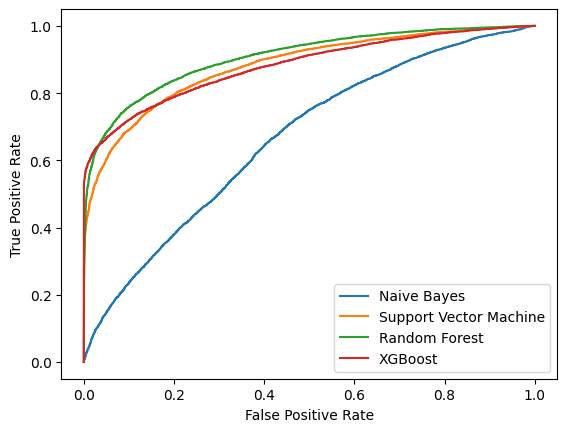

In [166]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(test_nb['real'], test_nb['score'])
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_svm['real'], test_svm['score'])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_rf['real'], test_rf['score'])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(test_xgb['real'], test_xgb['score'])

plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_svm, tpr_svm, label='Support Vector Machine')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show

Por lo tanto, tomando tomando todo lo anterior, podemos ver que el modelo de Random Forest es el que presenta mejores resultados para este problema en particular, y según las métricas enunciadas, son buenos resultados, ya que tiene un AUC de 0.91 (1 es el máximo), y una precisión sobre la clase 1 (atraso) de un 87%.

Es importante destacar que las métricas fueron calculadas a partir de la base de test, es decir, el modelo nunca vio estos datos a la hora de ser entrenado, por lo que se descarta el sobreajuste.

Finalmente, podemos afirmar que con los datos que se tienen, se puede detectar un patrón de estos que permite estimar con una alta tasa de aprobación si un vuelo se va a atrasar o no.

A continuación, para terminar las conclusiones acerca de los modelos vemos si una alta probabilidad de atraso según el modelo implica realmente una mayor cantidad de vuelos atrasados. Para esto se calculará el porcentaje de vuelos atrasados por decil de probabilidad

In [167]:
test_rf['decil'] = np.where(
    test_rf['score'] <= 0.1,
    1,
    np.where(
        ((test_rf.score > 0.1) & (test_rf.score <= 0.2)),
        2,
        np.where(
            ((test_rf.score > 0.2) & (test_rf.score <= 0.3)),
            3,
            np.where(
                ((test_rf.score > 0.3) & (test_rf.score <= 0.4)),
                4,
                np.where(
                    ((test_rf.score > 0.4) & (test_rf.score <= 0.5)),
                    5,
                    np.where(
                        ((test_rf.score > 0.5) & (test_rf.score <= 0.6)),
                        6,
                        np.where(
                            ((test_rf.score > 0.6) & (test_rf.score <= 0.7)),
                            7,
                            np.where(
                                ((test_rf.score > 0.7) & (test_rf.score <= 0.8)),
                                8,
                                np.where(
                                    ((test_rf.score > 0.8) & (test_rf.score <= 0.9)),
                                    9,
                                    10
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [168]:
rf_score_success = test_rf.groupby('decil').agg(atrasos = ('real','sum'), total = ('pred','count')).reset_index()
rf_score_success['pct_atrasos'] = rf_score_success['atrasos']/rf_score_success['total']

In [169]:
rf_score_success['decil'] = np.where(
    rf_score_success['decil'] == 1,
    '[0.0 , 0.1]',
    np.where(
        rf_score_success.decil == 2,
        '[0.1 , 0.2]',
        np.where(
            rf_score_success.decil == 3,
            '[0.2 , 0.3]',
            np.where(
                rf_score_success.decil == 4,
                '[0.3 , 0.4]',
                np.where(
                    rf_score_success.decil == 5,
                    '[0.4 , 0.5]',
                    np.where(
                        rf_score_success.decil == 6,
                        '[0.5 , 0.6]',
                        np.where(
                            rf_score_success.decil == 7,
                            '[0.6 , 0.7]',
                            np.where(
                                rf_score_success.decil == 8,
                                '[0.7 , 0.8]',
                                np.where(
                                    rf_score_success.decil == 9,
                                    '[0.8 , 0.9]',
                                    '[0.9 , 1.0]'
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

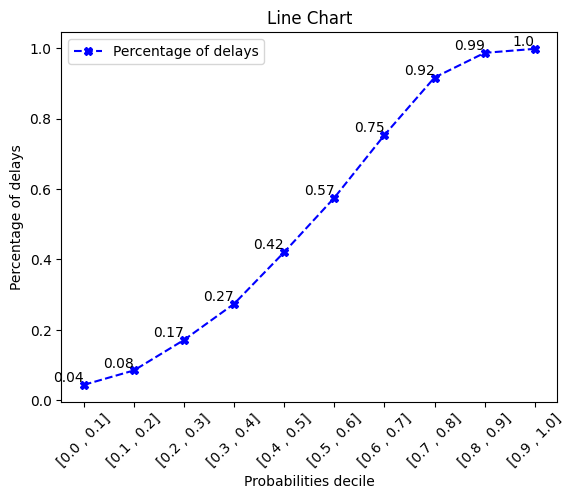

In [241]:

plt.plot(rf_score_success['decil'],rf_score_success['pct_atrasos'], marker='X', linestyle='--', color='blue', label='Percentage of delays')
plt.xlabel('Probabilities decile')
plt.ylabel('Percentage of delays')
plt.title('Line Chart')
plt.xticks(rotation = 45)

for i, j in zip(rf_score_success['decil'],rf_score_success['pct_atrasos']):
    plt.text(i, j, str(round(j,2)), ha='right', va='bottom')

plt.legend()
plt.show()

Efectivamente se cumple que a mayor score del modelo, o mayor probabilidad, se tiene un mayor porcentaje de atraso. Incluso, podemos ver que sobre el septimo decil, el modelo logra identificar a más del 95% de los casos de atrasos, por lo que se podría decir que aquellos vuelos con una probabilidad de sobre 0.7, es altamente probable que se atrasen (aunque suene obvio, el gráfico avala dicha afirmación).

# Feature importance

Existen varias técnicas y formas de analizar cuales son las variables más importantes dentro del modelo. En este caso se utilizó el método feature_importances_ disponible en el objeto del modelo de Random Forest.

In [ ]:
rf_feature_importance = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame(rf_feature_importance).T
rf_feature_importance.columns = X_train.columns

rf_feature_importance = rf_feature_importance.T
rf_feature_importance.columns = ['feature_importance']
rf_feature_importance = rf_feature_importance.sort_values('feature_importance')
rf_feature_importance = rf_feature_importance.reset_index().rename(columns={'index':'feature_name'})

,destiny_city_cd_CYYZ,destiny_city_cd_EGLL,destiny_city_cd_EGYP,destiny_city_cd_KATL,destiny_city_cd_KDFW,destiny_city_cd_KIAH,destiny_city_cd_KJFK,destiny_city_cd_KLAX,destiny_city_cd_KMCO,destiny_city_cd_KMIA,...,country_cd_SB,country_cd_SC,country_cd_SE,country_cd_SG,country_cd_SK,country_cd_SL,country_cd_SP,country_cd_SU,country_cd_YM,country_cd_YS
0,0.000575,0.000353,0.000012,0.000705,0.000606,0.000859,0.000738,0.000584,0.000087,0.00132,...,0.004114,0.005862,0.000998,0.000402,0.001901,0.000814,0.003691,0.001598,0.000222,0.000766


In [ ]:
top_50_rf_feature_importance = rf_feature_importance.sort_values('feature_importance',ascending = False).head(50)
top_50_rf_feature_importance = top_50_rf_feature_importance.sort_values('feature_importance')

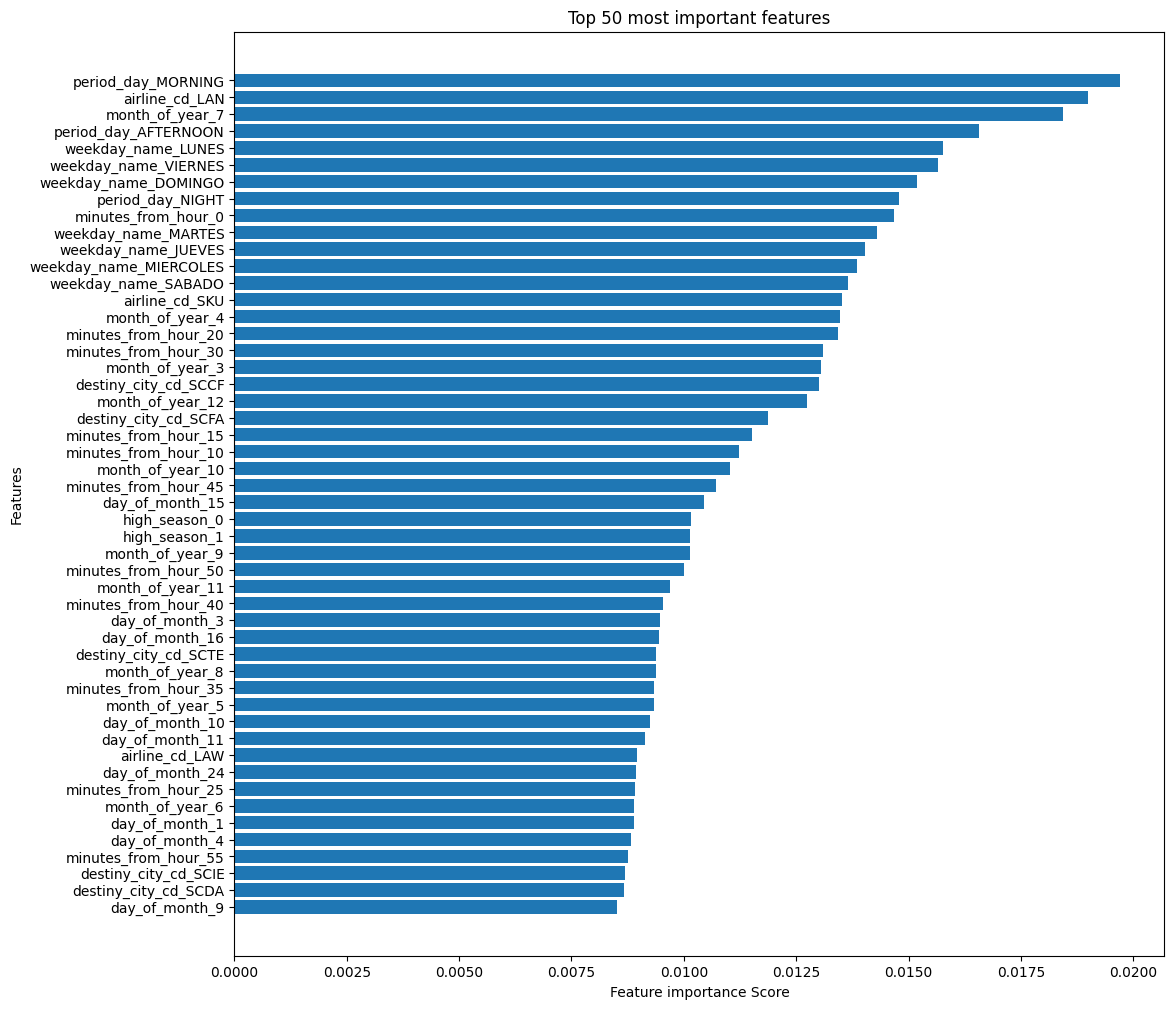

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12)) 
plt.barh(top_50_rf_feature_importance['feature_name'], top_50_rf_feature_importance['feature_importance'])
plt.xlabel('Feature importance Score')
plt.ylabel('Features')
plt.title('Top 50 most important features')

plt.show()


En el gráfico podemos ver las 50 features más importantes del modelo de Random Forest. Dentro del top 10 más importantes podemos encontrar las 3 opciones de periodo del día, por lo que claramente es una variable importante para el modelo.

También están todas las opciones de la variable día de la semana en el top 13.

Finalmente, en el top 15, podemos encontrar presente los 2 meses más extremos en porcentaje de atrasos según el EDA realizado, julio con más atrasos y abril con menos atrasos; además de encontrar las features de las 2 aerolineas con mayor cantidad de vuelos, LAN y SKU.

Por lo tanto, en el top 15 encontramos:
- Todas las opciones de period_day (3 en total)
- Todas las opciones de weekday_name (7 en total)
- Los meses más relevantes según el EDA realizado (2)
- Las aerolineas más relevantes según el EDA realizado (2)
- La feature asociada al minuto 0 de salida (por ejemplo si un vuelo sale a las 15:00, esta feature sería un 1)

# Conclusión

- De los datos obtenidos efectivamente se puede detectar un patrón que permite determinar con cierta probabilidad si un vuelo se va atrasar.
- El modelo de Random Forest es el que entrega mejores resultados sobre la base de test.
- Las predicciones realizadas con el modelo hacen sentido y tienen una relación positiva con el porcentaje de vuelos atrasados (a mayor probabilidad predicha, mayor cantidad de vuelos atrasados).
- Las features más relevantes para el modelo son el momento del día en que se programa un vuelo, el día de la semana en que se programa un vuelo, si el vuelo salió en julio o en abril, o si la aerolinea es LAN o SKU. Lo cuál hace sentido según el análisis realizado.

## Propuestas para el trabajo futuro

Si bien los resultados obtenidos son muy positivos, se está prediciendo data del mismo año. Esto quiere decir que a la hora de entrenar los modelos, estos quedan con el conocimiento de como fueron las tendencias del año (meses con mayor atrasos, momentos del día con mayor atraso, etc.), y luego predice sobre datos que no ha visto (base de test), pero que si tienen ese mismo comportamiento subyacente, debido a que son datos de vuelos también del mismo periodo de tiempo en el que se entrenó el modelo.

Es por esto que se sugiere predecir sobre data de un año completamente nuevo, de tal manera que el modelo no tenga información de las tendencias de dicho año, y así efectivamente validar el buen (o mal) desempeño del modelo. Es decir, se requiere hacer este paso para corroborar si el modelo es bueno extrapolando sus resultados a nuevos periodos de tiempo.